# **Study 4 – Preprocessing & Visualisations**

This notebook performs all preprocessing, recoding, descriptive analyses, data visualisation,for the *Linguistic Tailoring Intervention*.


## **Notebook Structure**

**1. Data Preparation**
- Data preprocessing  
- Variable recoding and construction of analysis features  

**2. Descriptive Statistics**
- Descriptive analyses  
- Visualisations of key variables and distributions  

**3. Visualisations**
- **Hypothesis 1**  
  - *Does receiving intervention messages (vs. no intervention) and receiving a tailored message (vs. a non-tailored message) influence lunch choice? (between-subjects*

- **Hypothesis 1**  
  - *Does receiving intervention messages (vs. no intervention) and receiving a tailored message (vs. a non-tailored message) influence lunch choice? (within-subjects)*

- **Hypothesis 2 – Message Responses**
  - H2a: Message Liking
  - H2b: Message shareability
  - H2c: Perceived relevance  
  - H2d: Perceived personalization  
  - H2e: Perceived linguistic style similarity
  - 
- **Hypothesis 3 – Source Responses**
  - H3a: Source liking  
  - H3b: Source trust  
  - H3c: Perceived source similarity  


In [6]:
#Loading packages
import pandas as pd

In [3]:
import bambi as bmb
pd.set_option('display.max_columns', None)

In [7]:
# General config & paths

from pathlib import Path

# Project root = folder where this notebook lives
PROJECT_ROOT = Path().resolve()

# Data folders (relative paths)
DATA_DIR = PROJECT_ROOT / "data"
ANALYSIS_DIR = DATA_DIR / "analysis"

In [8]:
#Loading in the different datafiles

daily_surveys_long = pd.read_csv(ANALYSIS_DIR  / "daily_surveys_long.csv")
daily_surveys_filtered = pd.read_csv(ANALYSIS_DIR  / "daily_surveys_filtered.csv")
daily_surveys_filtered2 = pd.read_csv(ANALYSIS_DIR  / "daily_surveys_filtered2.csv")
daily_surveys_imp = pd.read_csv(ANALYSIS_DIR  / "daily_surveys_long_imputed.csv")
weekend_surveys = pd.read_csv(ANALYSIS_DIR  / "weekend_surveys.csv")


# Rename condition_x to condition if it exists
for df in [daily_surveys_long, daily_surveys_filtered, daily_surveys_imp, weekend_surveys]:
    if "condition_x" in df.columns:
        df.rename(columns={"condition_x": "condition"}, inplace=True)

## Data Preprocessing and Variable Recoding

In [9]:
weekend_surveys["condition"].value_counts()

condition
3.0    458
1.0    448
2.0    446
5.0    234
4.0    228
Name: count, dtype: int64

In [10]:
# We compute a compound measure for plant-based food consumption at baseline

pb_lunch_baseline = weekend_surveys[weekend_surveys["Week"] == 0][["Name", "Lunch_plantbased", "Breakfast_plantbased", "Dinner_plantbased", "Snacks_omnivore"]]

In [30]:
pb_lunch_baseline.rename(
    columns={
        "Lunch_plantbased": "Lunch_baseline",
        "Breakfast_plantbased": "Breakfast_baseline",
        "Dinner_plantbased": "Dinner_baseline",
        "Snacks_omnivore": "Snacks_baseline"
    },
    inplace=True
)

In [31]:
# We do the same thing for baseline level omnivore food consumption
pb_lunch_baseline["Baseline_carnivore"] = pb_lunch_baseline[["Lunch_baseline", "Breakfast_baseline", "Dinner_baseline"]].mean(axis = 1)

pb_lunch_baseline["Baseline_carnivore"]

0       2.666667
3       1.000000
7       1.666667
9       1.000000
12      1.333333
          ...   
1800    5.000000
1802    5.000000
1806    3.666667
1808    2.000000
1812    2.000000
Name: Baseline_carnivore, Length: 606, dtype: float64

In [32]:
print(len(daily_surveys_long))
daily_surveys_long = daily_surveys_long.merge(pb_lunch_baseline, how = "left", on = "Name")
print(len(daily_surveys_long))
print(len(daily_surveys_filtered))
daily_surveys_filtered = daily_surveys_filtered.merge(pb_lunch_baseline, how = "left", on = "Name")
daily_surveys_filtered2 = daily_surveys_filtered2.merge(pb_lunch_baseline, how = "left", on = "Name")
print(len(daily_surveys_filtered))
daily_surveys_imp = daily_surveys_imp.merge(pb_lunch_baseline, how = "left", on = "Name")
weekend_surveys = weekend_surveys.merge(pb_lunch_baseline, how = "left", on = "Name")

print(len(daily_surveys_filtered2))

6780
6780
5860
5860
6130


In [33]:
#Some small adjustment

daily_surveys_melted = daily_surveys_filtered.copy()
daily_surveys_melted['condition'] = daily_surveys_melted['condition'].replace(5, 4)

daily_surveys_filtered2 = daily_surveys_filtered2.rename(columns={'condition_x': 'condition'})

In [34]:
print(len(daily_surveys_long))
print(len(daily_surveys_filtered))
print(len(daily_surveys_filtered2))
print(len(daily_surveys_imp))
print(len(weekend_surveys))

6780
5860
6130
6130
1814


In [35]:
#We transform the condition variable into a simple planned contrast - No intervention vs. intervention message

daily_surveys_long["Intervention"] = daily_surveys_long["condition"].astype(float).apply(lambda x: "No" if x == 1.0 else "Yes")
daily_surveys_filtered["Intervention"] = daily_surveys_filtered["condition"].astype(float).apply(lambda x: "No" if x == 1.0 else "Yes")
daily_surveys_filtered2["Intervention"] = daily_surveys_filtered2["condition"].astype(float).apply(lambda x: "No" if x == 1.0 else "Yes")
daily_surveys_imp["Intervention"] = daily_surveys_imp["condition"].astype(float).apply(lambda x: "No" if x == 1.0 else "Yes")
daily_surveys_melted["Intervention"] = daily_surveys_melted["condition"].astype(float).apply(lambda x: "No" if x == 1.0 else "Yes")
weekend_surveys["Intervention"] = weekend_surveys["condition"].astype(float).apply(lambda x: "No" if x == 1.0 else "Yes")

print(len(daily_surveys_filtered))

5860


In [36]:
weekend_surveys = weekend_surveys.rename(columns={'Week': 'week'})

In [37]:
#We compute another planned contrast for all DFs: Tailored message vs. non-tailored message

import numpy as np

def get_tailored(row):
    condition = row["condition"]
    week = row["week"]

    if condition == 1:
        return "NA"
    if condition == 2:
        return "No"
    elif condition == 3:
        return "Yes"
    elif condition == 4:
        return "Yes" if (week == 1 or week == 0)  else "No"
    elif condition == 5:
        return "No" if (week == 1 or week == 0)  else "Yes"
    else:
        return np.nan

daily_surveys_long["Tailored"] = daily_surveys_long.apply(get_tailored, axis=1)
daily_surveys_filtered["Tailored"] = daily_surveys_filtered.apply(get_tailored, axis=1)
daily_surveys_filtered2["Tailored"] = daily_surveys_filtered2.apply(get_tailored, axis=1)
daily_surveys_imp["Tailored"] = daily_surveys_imp.apply(get_tailored, axis=1)
daily_surveys_melted["Tailored"] = daily_surveys_melted.apply(get_tailored, axis=1)
weekend_surveys["Tailored"] = weekend_surveys.apply(get_tailored, axis=1)

print(len(daily_surveys_filtered))

5860


In [39]:
import numpy as np

# Binary recode map: 2/3 = plant-based (1), 1 = not plant-based (0), 0 = missing/other
lunch_map = {2: 1, 3: 1, 1: 0, 0: np.nan}

dfs = [
    daily_surveys_long,
    daily_surveys_filtered,
    daily_surveys_filtered2,
    daily_surveys_imp,
    daily_surveys_melted,
    weekend_surveys,
]

# Filter out rows with NaN in Lunch_plantbased and create binary version
for i, df in enumerate(dfs):
    df = df[pd.notna(df["Lunch_plantbased"])].copy()
    df["Lunch_plantbased2"] = df["Lunch_plantbased"].map(lunch_map)
    dfs[i] = df  # reassign cleaned version

(
    daily_surveys_long,
    daily_surveys_filtered,
    daily_surveys_filtered2,
    daily_surveys_filtered_imp,
    daily_surveys_melted,
    weekend_surveys,
) = dfs

print(len(daily_surveys_filtered_imp))

6060


In [42]:
print(daily_surveys_filtered["Lunch_plantbased2"].value_counts(dropna=False))
print(len(daily_surveys_filtered))

Lunch_plantbased2
1.0    2830
0.0    2543
NaN     104
Name: count, dtype: int64
5477


In [43]:
# Now lets do the planned contrast coding for the intervention and tailoring contrast numerically

weekend_surveys
daily_surveys_long['Intervention_contrast'] = daily_surveys_long['Intervention'].map({'No': -0.66666, 'Yes': 0.33333})
daily_surveys_filtered['Intervention_contrast'] = daily_surveys_filtered['Intervention'].map({'No': -0.66666, 'Yes': 0.33333})
daily_surveys_filtered2['Intervention_contrast'] = daily_surveys_filtered2['Intervention'].map({'No': -0.66666, 'Yes': 0.33333})
daily_surveys_filtered_imp['Intervention_contrast'] = daily_surveys_filtered_imp['Intervention'].map({'No': -0.66666, 'Yes': 0.33333})
daily_surveys_melted['Intervention_contrast'] = daily_surveys_melted['Intervention'].map({'No': -0.66666, 'Yes': 0.33333})
weekend_surveys['Intervention_contrast'] = weekend_surveys['Intervention'].map({'No': -0.66666, 'Yes': 0.33333})

daily_surveys_long['Tailored_contrast'] = daily_surveys_long['Tailored'].map({'No': -0.5, 'Yes': 0.5, "NA": 0})
daily_surveys_filtered['Tailored_contrast'] = daily_surveys_filtered['Tailored'].map({'No': -0.5, 'Yes': 0.5, "NA": 0})
daily_surveys_filtered2['Tailored_contrast'] = daily_surveys_filtered2['Tailored'].map({'No': -0.5, 'Yes': 0.5, "NA": 0})
daily_surveys_filtered_imp['Tailored_contrast'] = daily_surveys_filtered_imp['Tailored'].map({'No': -0.5, 'Yes': 0.5, "NA": 0})
daily_surveys_melted['Tailored_contrast'] = daily_surveys_melted['Tailored'].map({'No': -0.5, 'Yes': 0.5, "NA": 0})
weekend_surveys['Tailored_contrast'] = weekend_surveys['Tailored'].map({'No': -0.5, 'Yes': 0.5, "NA": 0})

In [44]:
#Check if the distribution is right

daily_surveys_long['Intervention_contrast'].value_counts()

Intervention_contrast
 0.33333    4663
-0.66666    1416
Name: count, dtype: int64

In [45]:
#Check if the distribution is right

unique_observations = daily_surveys_filtered[["week", "condition", "Intervention_contrast", "Tailored_contrast"]].drop_duplicates()
print(unique_observations)

     week  condition  Intervention_contrast  Tailored_contrast
0       1        2.0                0.33333               -0.5
5       2        2.0                0.33333               -0.5
10      1        3.0                0.33333                0.5
15      2        3.0                0.33333                0.5
20      1        5.0                0.33333               -0.5
25      2        5.0                0.33333                0.5
40      1        4.0                0.33333                0.5
45      2        4.0                0.33333               -0.5
100     1        1.0               -0.66666                0.0
105     2        1.0               -0.66666                0.0


In [25]:
#Check if the distribution is right

daily_surveys_melted["Tailored_contrast"].value_counts()

Tailored_contrast
 0.5    2104
-0.5    2048
 0.0    1325
Name: count, dtype: int64

In [46]:
#Next we need to adjust the value for the Day variable. From 1-10 to 1-5 within week 1 and week 2 respecitvelt

# Define the mapping of Day values for Week 2
day_map = {6: 1, 7: 2, 8: 3, 9: 4, 10: 5}

# --- Apply to daily_surveys_long ---
daily_surveys_long = daily_surveys_long.copy()
daily_surveys_long["Day2"] = daily_surveys_long["Day"]
mask = daily_surveys_long["week"] == 2
daily_surveys_long.loc[mask, "Day2"] = daily_surveys_long.loc[mask, "Day"].map(day_map)

# --- Apply to daily_surveys_filtered ---
daily_surveys_filtered = daily_surveys_filtered.copy()
daily_surveys_filtered["Day2"] = daily_surveys_filtered["Day"]
mask_filtered = daily_surveys_filtered["week"] == 2
daily_surveys_filtered.loc[mask_filtered, "Day2"] = daily_surveys_filtered.loc[mask_filtered, "Day"].map(day_map)

# --- Apply to daily_surveys_filtered2 ---
daily_surveys_filtered2 = daily_surveys_filtered2.copy()
daily_surveys_filtered2["Day2"] = daily_surveys_filtered2["Day"]
mask_filtered2 = daily_surveys_filtered2["week"] == 2
daily_surveys_filtered2.loc[mask_filtered2, "Day2"] = daily_surveys_filtered2.loc[mask_filtered2, "Day"].map(day_map)

# --- Apply to daily_surveys_filtered_imp ---
daily_surveys_filtered_imp = daily_surveys_filtered_imp.copy()
daily_surveys_filtered_imp["Day2"] = daily_surveys_filtered_imp["Day"]
mask_imp = daily_surveys_filtered_imp["week"] == 2
daily_surveys_filtered_imp.loc[mask_imp, "Day2"] = daily_surveys_filtered_imp.loc[mask_imp, "Day"].map(day_map)

# --- Apply to daily_surveys_melted ---
daily_surveys_melted = daily_surveys_melted.copy()
daily_surveys_melted["Day2"] = daily_surveys_melted["Day"]
mask_melted = daily_surveys_melted["week"] == 2
daily_surveys_melted.loc[mask_melted, "Day2"] = daily_surveys_melted.loc[mask_melted, "Day"].map(day_map)



In [47]:
# Define the mapping of Day values for Week 2
day_map2 = {6: 8, 7: 9, 8: 10, 9: 11, 10: 12}
# Replace values in the 'Day' column
daily_surveys_long["Day3"] = daily_surveys_long["Day"].replace(day_map2)
daily_surveys_filtered["Day3"] = daily_surveys_filtered["Day"].replace(day_map2)
daily_surveys_filtered2["Day3"] = daily_surveys_filtered2["Day"].replace(day_map2)
daily_surveys_filtered_imp["Day3"] = daily_surveys_filtered_imp["Day"].replace(day_map2)
daily_surveys_melted["Day3"] = daily_surveys_melted["Day"].replace(day_map2)

In [48]:
daily_surveys_filtered["Day3"].value_counts()

Day3
8     557
3     552
4     552
5     552
2     551
1     548
11    545
10    543
9     542
12    535
Name: count, dtype: int64

In [29]:
daily_surveys_filtered["Lunch_plantbased"].value_counts()

Lunch_plantbased
1.0    2543
2.0    1815
3.0    1015
0.0     104
Name: count, dtype: int64

In [30]:
daily_surveys_filtered["Lunch_plantbased2"].value_counts()

Lunch_plantbased2
1.0    2830
0.0    2543
Name: count, dtype: int64

In [49]:
#Gender will also be recoded into binary (female vs. male & other)

daily_surveys_long["Gender"].value_counts()
daily_surveys_long["Gender_dummy"] = (daily_surveys_long["Gender"] == 7.0).astype(int)
daily_surveys_filtered_imp["Gender_dummy"] = (daily_surveys_filtered_imp["Gender"] == 7.0).astype(int)
daily_surveys_filtered["Gender_dummy"] = (daily_surveys_filtered["Gender"] == 7.0).astype(int)
daily_surveys_filtered2["Gender_dummy"] = (daily_surveys_filtered2["Gender"] == 7.0).astype(int)
daily_surveys_melted["Gender_dummy"] = (daily_surveys_melted["Gender"] == 7.0).astype(int)
weekend_surveys["Gender_dummy"] = (weekend_surveys["Gender"] == 7.0).astype(int)

In [33]:
daily_surveys_filtered['Lunch_plantbased2'].groupby(daily_surveys_filtered['Lunch_availability']).mean()

Lunch_availability
1.0    0.207096
2.0    0.377049
3.0    0.654216
Name: Lunch_plantbased2, dtype: float64

In [34]:
daily_surveys_filtered['Lunch_availability'].value_counts()

Lunch_availability
3.0    3776
1.0    1421
2.0     280
Name: count, dtype: int64

In [50]:
# Select columns Day1 to Day10
day_columns = [f'Day {i}' for i in range(1, 11)]

# Calculate the row-wise sum
row_sums = daily_surveys_filtered2[day_columns].sum(axis=1)

# Count how many rows sum to exactly 10
count_exact_10 = (row_sums == 10).sum()

# Calculate mean and standard deviation of row sums
mean_sum = row_sums.mean()
std_sum = row_sums.std()

# Print results
print(f"Number of rows where sum equals 10: {count_exact_10}")
print(f"Mean of row sums: {mean_sum:.2f}")
print(f"Standard deviation of row sums: {std_sum:.2f}")


Number of rows where sum equals 10: 2130
Mean of row sums: 8.58
Standard deviation of row sums: 1.74


In [53]:
#Recoding of the lunch availability column

daily_surveys_long["Lunch_availability"].value_counts()

# Define mapping
availability_mapping = {1: 0, 2: 1, 3: 1}

# Apply mapping
daily_surveys_long["Lunch_availability"] = daily_surveys_long["Lunch_availability"].replace(availability_mapping)
daily_surveys_filtered["Lunch_availability"] = daily_surveys_filtered["Lunch_availability"].replace(availability_mapping)
daily_surveys_filtered2["Lunch_availability"] = daily_surveys_filtered2["Lunch_availability"].replace(availability_mapping)
daily_surveys_filtered_imp["Lunch_availability"] = daily_surveys_filtered_imp["Lunch_availability"].replace(availability_mapping)
daily_surveys_melted["Lunch_availability"] = daily_surveys_melted["Lunch_availability"].replace(availability_mapping)

In [55]:
#Recoding of the Imposter variable

daily_surveys_long["Imposter"] = daily_surveys_long["Imposter"].fillna(1)
daily_surveys_filtered["Imposter"] = daily_surveys_filtered["Imposter"].fillna(1)
daily_surveys_filtered2["Imposter"] = daily_surveys_filtered2["Imposter"].fillna(1)
daily_surveys_filtered_imp["Imposter"] = daily_surveys_filtered_imp["Imposter"].fillna(1)
daily_surveys_melted["Imposter"] = daily_surveys_melted["Imposter"].fillna(1)
weekend_surveys["Imposter"] = weekend_surveys["Imposter"].fillna(1)

In [43]:
#We can now save the preprocessed data file

#daily_surveys_filtered2.to_csv(ANALYSIS_DIR / 'daily_surveys_filtered2_python2.csv')

In [44]:
#weekend_surveys.to_csv(ANALYSIS_DIR /"weekend_surveys_python2.csv")

## Descrtiptive Anlaysis & Data Visualisation

In [63]:
#Lets run some descriptive statistics on message resposne variables


columns_to_report = [
    'Message_liking', 'Message_shareability', 'Message_relevance'
]

# Group by condition and calculate mean & std
summary_table = daily_surveys_filtered2.groupby("condition")[columns_to_report].agg(['mean', 'std'])

# Optional: round values for readability
summary_table = summary_table.round(2)

print(summary_table)

          Message_liking       Message_shareability       Message_relevance  \
                    mean   std                 mean   std              mean   
condition                                                                     
1.0                  NaN   NaN                  NaN   NaN               NaN   
2.0                 2.55  0.60                 2.45  0.64              5.74   
3.0                 2.56  0.62                 2.53  0.65              5.87   
4.0                 2.51  0.63                 2.43  0.70              5.68   
5.0                 2.64  0.59                 2.56  0.62              5.95   

                 
            std  
condition        
1.0         NaN  
2.0        1.24  
3.0        1.23  
4.0        1.36  
5.0        1.24  


In [64]:
#Lets run some descriptive statistics

columns_to_report = [
    'Attitude_instrument', 'Attitude_experiential', 'Perceived_similarity',
    'Source_liking', 'Source_trust', 'Intention_plantbased',
    'Message_personalized', 'Message_similarity', 'Tailroing_attitude1'
]

# Group by condition and calculate mean & std
summary_table = weekend_surveys.groupby("condition")[columns_to_report].agg(['mean', 'std'])

# Optional: round values for readability
summary_table = summary_table.round(2)

print(summary_table)

          Attitude_instrument       Attitude_experiential        \
                         mean   std                  mean   std   
condition                                                         
1.0                      3.29  0.70                  3.22  0.81   
2.0                      3.42  0.62                  3.32  0.77   
3.0                      3.48  0.64                  3.37  0.81   
4.0                      3.40  0.61                  3.30  0.79   
5.0                      3.53  0.59                  3.52  0.64   

          Perceived_similarity       Source_liking       Source_trust        \
                          mean   std          mean   std         mean   std   
condition                                                                     
1.0                        NaN   NaN           NaN   NaN          NaN   NaN   
2.0                       4.16  1.30          3.34  0.63         3.35  0.64   
3.0                       4.25  1.27          3.46  0.58         3.4

In [66]:
#We can now display crosstabs how plant-based lunch choices varied per day and per intervention condition

pd.crosstab(daily_surveys_filtered2["Day3"],
            daily_surveys_filtered2["Intervention_contrast"],
            values=daily_surveys_filtered2["Lunch_plantbased2"],
            aggfunc="mean")

Intervention_contrast,-0.66666,0.33333
Day3,,
1,0.456522,0.442623
2,0.448529,0.519814
3,0.482014,0.510441
4,0.420290,0.536817
5,0.474074,0.518692
8,0.437037,0.583908
9,0.496241,0.585542
10,0.446970,0.563107
11,0.477941,0.547847


C:\Users\77197jsc\AppData\Local\Temp\ipykernel_9388\3874379448.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=mean_intervention, x='Intervention_contrast', y='Lunch_plantbased2', palette='Set2')


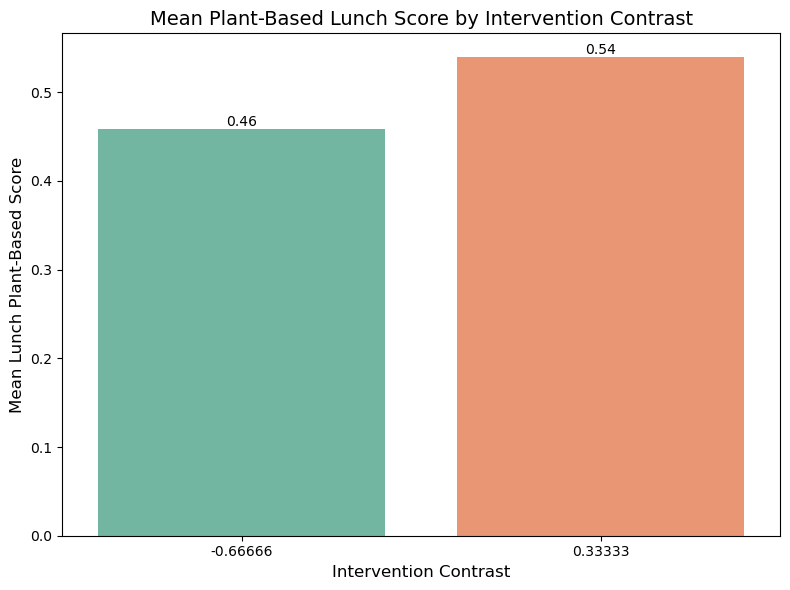

In [67]:
#Lets draw a simple barplot of plant-based food chocies across intervention contrast

import seaborn as sns
import matplotlib.pyplot as plt

# Group by Intervention_contrast and calculate mean
mean_intervention = daily_surveys_filtered2.groupby('Intervention_contrast')['Lunch_plantbased2'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=mean_intervention, x='Intervention_contrast', y='Lunch_plantbased2', palette='Set2')

# Annotate each bar with the mean value
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.title('Mean Plant-Based Lunch Score by Intervention Contrast', fontsize=14)
plt.xlabel('Intervention Contrast', fontsize=12)
plt.ylabel('Mean Lunch Plant-Based Score', fontsize=12)
#plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [50]:
weekend_surveys['Lunch_plantbased'].groupby(weekend_surveys["condition"]).mean()

condition
1.0    3.337808
2.0    3.650224
3.0    3.478166
4.0    3.399123
5.0    3.470085
Name: Lunch_plantbased, dtype: float64

In [51]:
### Anova 

C:\Users\77197jsc\AppData\Local\Temp\ipykernel_9388\2573612816.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=mean_intervention, x='Tailored_contrast', y='Lunch_plantbased2', palette='Set2')


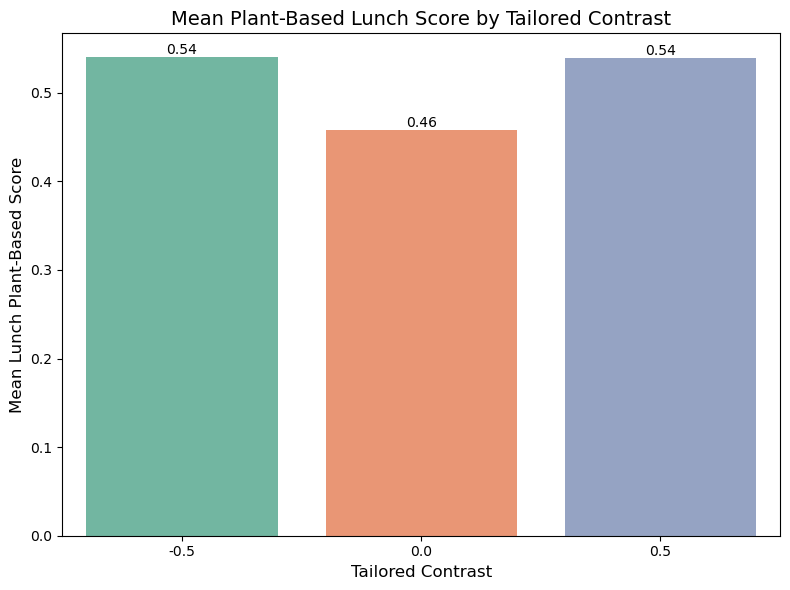

In [68]:
# We also went to visualise the difference across the tailoring contrast (tailroed vs. non-tailored messages)

import seaborn as sns
import matplotlib.pyplot as plt

# Group by Intervention_contrast and calculate mean
mean_intervention = daily_surveys_filtered2.groupby('Tailored_contrast')['Lunch_plantbased2'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=mean_intervention, x='Tailored_contrast', y='Lunch_plantbased2', palette='Set2')

# Annotate each bar with the mean value
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.title('Mean Plant-Based Lunch Score by Tailored Contrast', fontsize=14)
plt.xlabel('Tailored Contrast', fontsize=12)
plt.ylabel('Mean Lunch Plant-Based Score', fontsize=12)
#plt.ylim(0, 1)
plt.tight_layout()
plt.show()

C:\Users\77197jsc\AppData\Local\Temp\ipykernel_9388\2632716416.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=mean_intervention, x='condition', y='Lunch_plantbased2', palette='Set2')


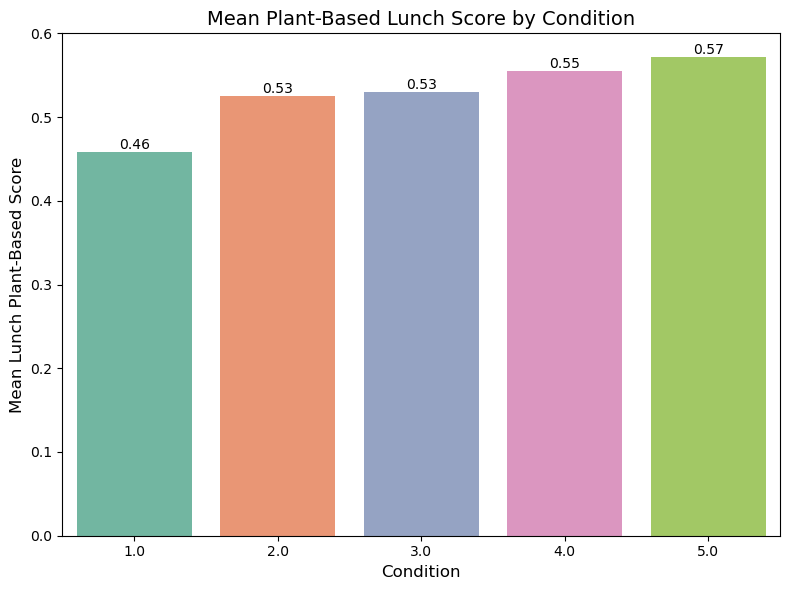

In [69]:
#And lastly we can plot the difference in the main outcome for each single condition separately

import seaborn as sns
import matplotlib.pyplot as plt

# Group by Intervention_contrast and calculate mean
mean_intervention = daily_surveys_filtered2.groupby('condition')['Lunch_plantbased2'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data=mean_intervention, x='condition', y='Lunch_plantbased2', palette='Set2')

# Annotate each bar with the mean value
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=10)

# Customize the plot
plt.title('Mean Plant-Based Lunch Score by Condition', fontsize=14)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Mean Lunch Plant-Based Score', fontsize=12)
#plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [70]:
daily_surveys_long["Lunch_plantbased2"].groupby(daily_surveys_long["condition"]).mean()

condition
1.0    0.459632
2.0    0.519763
3.0    0.530080
4.0    0.541176
5.0    0.563307
Name: Lunch_plantbased2, dtype: float64

In [72]:
#Lets calculate the standard error per condition

from scipy.stats import sem

# Step 1: Compute SEM per condition
sem_per_condition = (
    daily_surveys_filtered
    .groupby('condition')['Lunch_plantbased2']
    .agg(score_sem=sem)
    .reset_index()
)

# Step 2: Merge SEM back into the original DataFrame
daily_surveys_filtered = daily_surveys_filtered.merge(
    sem_per_condition, on='condition', how='left'
)

# Drop NaNs first
filtered_df = daily_surveys_filtered[['condition', 'Lunch_plantbased2']].dropna()

# Compute SEM per condition
sem_per_condition = (
    filtered_df
    .groupby('condition')['Lunch_plantbased2']
    .agg(score_sem=lambda x: sem(x, nan_policy='omit'))
    .reset_index()
)

print(sem_per_condition)

   condition  score_sem
0        1.0   0.013712
1        2.0   0.013764
2        3.0   0.013517
3        4.0   0.018906
4        5.0   0.018830


### Data Visualisation

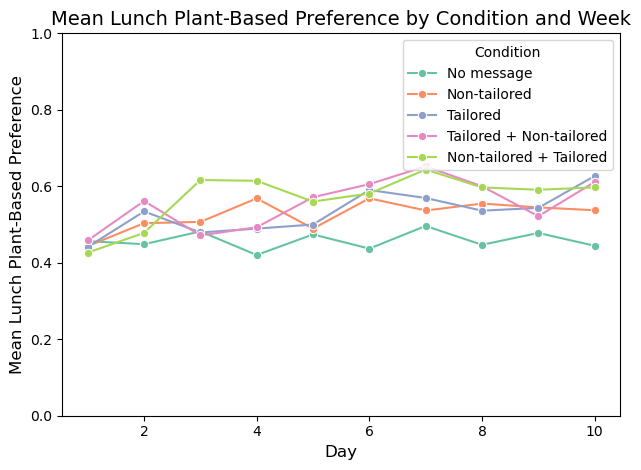

In [73]:
#If we take each day as a datapoint the graph looks like this

import seaborn as sns

# Step 1: Define label mapping
condition_labels = {
    1: "No message",
    2: "Non-tailored",
    3: "Tailored",
    4: "Tailored + Non-tailored",
    5:"Non-tailored + Tailored",
}

# Step 2: Map labels in a new column
mean_values = daily_surveys_filtered2.groupby(['condition', 'Day'])['Lunch_plantbased2'].mean().reset_index()
mean_values['condition_label'] = mean_values['condition'].map(condition_labels)

# Step 3: Plot with custom labels
custom_palette = sns.color_palette("Set2", n_colors=len(condition_labels))
sns.lineplot(data=mean_values, x='Day', y='Lunch_plantbased2', hue='condition_label',
             marker='o', palette=custom_palette)

# Step 4: Customize plot
plt.title('Mean Lunch Plant-Based Preference by Condition and Week', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Mean Lunch Plant-Based Preference', fontsize=12)
plt.legend(title='Condition', loc='upper right')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

### Hypothesis 1: Does the receiving messages (vs. not receiving message) affect lunch choice?

In [827]:
daily_surveys_filtered.groupby(["Intervention_contrast"])["Lunch_plantbased2"].mean()

Intervention_contrast
-0.88888    0.457229
 0.22222    0.549358
Name: Lunch_plantbased2, dtype: float64

In [828]:
daily_surveys_long.columns

Index(['Unnamed: 0.2', 'Name', 'Day', 'Message_liking', 'Message_shareability',
       'Message_dislike_reason', 'Message_relevance', 'Lunch_open',
       'Lunch_plantbased', 'Lunch_availability', 'week', 'User ID_x',
       'condition', 'Unnamed: 0.1', 'Unnamed: 0', 'User ID_y', 'Baseline',
       'Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Weekend 1', 'Day 6',
       'Day 7', 'Day 8', 'Day 9', 'Day 10', 'Weekend 2', 'Norstat ID_x',
       'condition_y', 'ID', 'Movez ID', 'Norstat ID', 'Message_exposure',
       'Mail_child_exp', 'Mail_child_ctr', 'Country_of_residence',
       'Country_of_residence_6_TEXT', 'Dietary_identity',
       'Dietary_identity_6_TEXT', 'Children_age_years', 'Birthplace_parents',
       'Ethnic_group', 'Ethnic_group_5_TEXT', 'SES_education', 'SES_income_UK',
       'SES_income_ROI', 'Random ID', 'id', 'SES', 'Child_ID', 'Mail_child',
       'Imposter', 'Game_pleasure', 'Game_relatedness', 'Game_capability',
       'Sharing_behavior_gam', 'Game_rating', 'Game

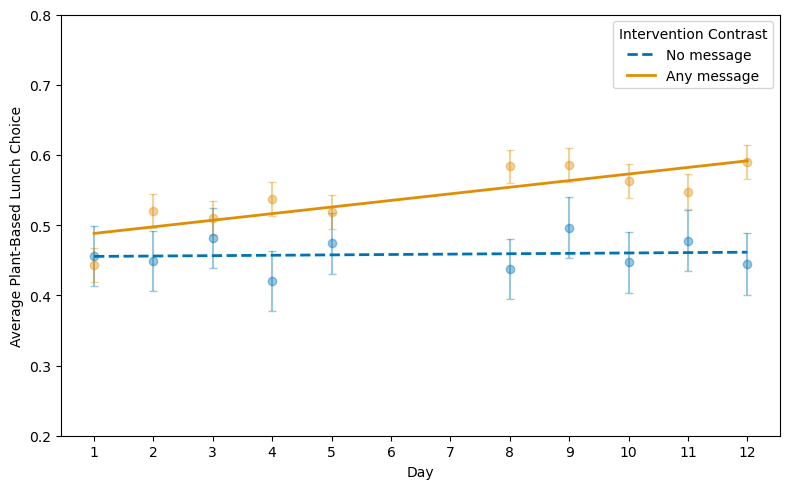

In [74]:
#Plotting the linear difference between the conditions in the Intervention contrast

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define label mapping and linetypes
label_map = {
    "No": "No message",
    "Yes": "Any message"
}
linetypes = {
    "No": "dashed",
    "Yes": "solid"
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Use colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=2)
colors = dict(zip(["No", "Yes"], palette))

# Plot only points with error bars (no connecting line)
summary = daily_surveys_filtered2.groupby(["Intervention", "Day3"])["Lunch_plantbased2"].agg(['mean', 'sem']).reset_index()

for intervention in summary["Intervention"].unique():
    sub = summary[summary["Intervention"] == intervention]
    plt.errorbar(
        sub["Day3"], sub["mean"], yerr=sub["sem"],
        fmt='o', color=colors[intervention], alpha=0.4,
        label=None, capsize=3
    )

# Overlay regression lines, using different linetypes
for intervention in summary["Intervention"].unique():
    sub = summary[summary["Intervention"] == intervention]
    sns.regplot(
        data=sub,
        x="Day3",
        y="mean",
        scatter=False,
        ci=None,
        color=colors[intervention],
        line_kws={'linestyle': linetypes[intervention], 'linewidth': 2},
        label=label_map[intervention]
    )

# Customize plot
plt.xlabel("Day")
plt.ylabel("Average Plant-Based Lunch Choice")
plt.legend(title="Intervention Contrast")
plt.xticks(ticks=np.arange(1, 13, 1))
plt.ylim(0.2, 0.8)
plt.tight_layout()

# Save high-resolution image (300 dpi)
plt.savefig("plant_based_lunch_plot.png", dpi=300, bbox_inches='tight')

plt.show()


In [79]:
daily_surveys_filtered2.groupby(['Intervention_contrast', 'Day'])['Lunch_plantbased2'].mean().unstack()


Day,1,2,3,4,5,6,7,8,9,10
Intervention_contrast,,,,,,,,,,
-0.66666,0.456522,0.448529,0.482014,0.420290,0.474074,0.437037,0.496241,0.446970,0.477941,0.444444
0.33333,0.442623,0.519814,0.510441,0.536817,0.518692,0.583908,0.585542,0.563107,0.547847,0.589806


In [81]:
#Some descriptive statiscs for the final intervention day and final day differences between groups

day10_stats = (
    daily_surveys_filtered2[daily_surveys_filtered2['Day'] == 10]
    .groupby('Intervention_contrast')['Lunch_plantbased2']
    .agg(['mean', 'std', 'count'])
)

# Add SEM column
day10_stats['sem'] = day10_stats['std'] / np.sqrt(day10_stats['count'])

# Show result
day10_stats

,mean,std,count,sem
Intervention_contrast,,,,
-0.66666,0.444444,0.498888,126,0.044444
0.33333,0.589806,0.492467,412,0.024262


In [83]:
#More statistics about within group and week average lunch choices

daily_surveys_filtered2.groupby(['condition', "week"])['Lunch_plantbased2'].mean().unstack()


week,1,2
condition,,
1.0,0.456268,0.460725
2.0,0.502122,0.548711
3.0,0.488858,0.573082
4.0,0.511236,0.598291
5.0,0.540845,0.602273


### Hypothesis 2: Does receiving a tailored message (vs. a non-tailroed message) have an effect on lunch choice?


In [60]:
df = daily_surveys_filtered2[daily_surveys_filtered2['condition'].isin([1.0, 2.0, 3.0])]
df.groupby(["Tailored_contrast"])["Lunch_plantbased2"].mean()

Tailored_contrast
-0.5    0.525267
 0.0    0.458457
 0.5    0.530163
Name: Lunch_plantbased2, dtype: float64

In [63]:
daily_surveys_filtered2['condition'].head()

0    2.0
1    2.0
2    2.0
3    2.0
4    2.0
Name: condition, dtype: float64

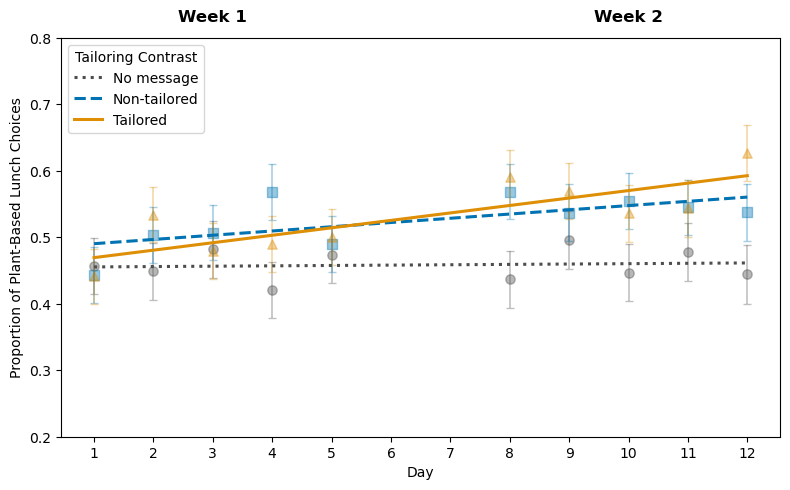

In [87]:
#First we can plot the difference across the Tailoring COntrast (between-subjects analysis)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter for relevant conditions
df = daily_surveys_filtered2[daily_surveys_filtered2['condition'].isin([1.0, 2.0, 3.0])]

# Group and calculate mean and SEM
summary = df.groupby(["condition", "Day3"])["Lunch_plantbased2"].agg(['mean', 'sem']).reset_index()

# Label mapping, linetypes, markers, colors
label_map = {1.0: "No message", 2.0: "Non-tailored", 3.0: "Tailored"}
linetypes = {1.0: "dotted", 2.0: "dashed", 3.0: "solid"}
markers = {1.0: "o", 2.0: "s", 3.0: "^"}
colors = {
    1.0: "#4D4D4D",   # dark grey
    2.0: "#0173B2",   # seaborn colorblind blue
    3.0: "#DE8F05"    # seaborn colorblind orange
}

fig, ax = plt.subplots(figsize=(8, 5))

# 1) Faded error bars + 2) Faded points
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]

    # Faded error bars (no marker here)
    ax.errorbar(
        sub["Day3"], sub["mean"], yerr=sub["sem"],
        fmt='none', ecolor=colors[cond], elinewidth=1.2, capsize=3, alpha=0.35
    )

    # Faded points
    ax.scatter(
        sub["Day3"], sub["mean"],
        s=45, marker=markers[cond],
        facecolors=colors[cond], edgecolors=colors[cond],
        alpha=0.40, label=None
    )

# 3) Solid regression lines (no scatter, no alpha)
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]
    sns.regplot(
        data=sub, x="Day3", y="mean",
        scatter=False, ci=None,
        color=colors[cond],
        line_kws={'linestyle': linetypes[cond], 'linewidth': 2.2},
        label=label_map[cond],
        ax=ax
    )

# Axes, legend, ticks
ax.set_xlabel("Day")
ax.set_ylabel("Proportion of Plant-Based Lunch Choices")
ax.set_ylim(0.2, 0.8)
ax.set_xticks(np.arange(1, 13, 1))
ax.legend(title="Tailoring Contrast")

# Week labels (adjust y if your ylim changes)
ax.text(3, 0.82, "Week 1", ha="center", va="bottom", fontsize=12, fontweight="bold")
ax.text(10, 0.82, "Week 2", ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.savefig("plant_based_lunch_tailoring_contrast.png", dpi=300, bbox_inches='tight')
plt.show()


In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter for relevant conditions
df = daily_surveys_filtered2[daily_surveys_filtered2['condition'].isin([1.0, 2.0, 3.0])]

# Group and calculate mean and SEM
summary = df.groupby(["condition", "Day3"])["Lunch_plantbased2"].agg(['mean', 'sem']).reset_index()

# Style mappings
linetypes = {1.0: "dotted", 2.0: "dashed", 3.0: "solid"}
markers   = {1.0: "o", 2.0: "s", 3.0: "^"}
colors    = {1.0: "#4D4D4D", 2.0: "#0173B2", 3.0: "#DE8F05"}

fig, ax = plt.subplots(figsize=(8, 5))

# Error bars + points
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]

    ax.errorbar(
        sub["Day3"], sub["mean"], yerr=sub["sem"],
        fmt='none', ecolor=colors[cond], elinewidth=1.2, capsize=3, alpha=0.35
    )

    ax.scatter(
        sub["Day3"], sub["mean"],
        s=45, marker=markers[cond],
        facecolors=colors[cond], edgecolors=colors[cond],
        alpha=0.40
    )

# Regression lines
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]
    sns.regplot(
        data=sub, x="Day3", y="mean",
        scatter=False, ci=None,
        color=colors[cond],
        line_kws={'linestyle': linetypes[cond], 'linewidth': 2.2},
        ax=ax
    )

# ---- Remove labels, keep ticks ----
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0.2, 0.8)
ax.set_xticks(np.arange(1, 13, 1))

# Hide tick labels but keep ticks visible
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove legend and any added text
if ax.get_legend() is not None:
    ax.get_legend().remove()
for t in ax.texts:
    t.set_visible(False)

# Save as SVG
plt.savefig("Figure2_withoutannotation.svg", format="svg", bbox_inches='tight')
plt.close()


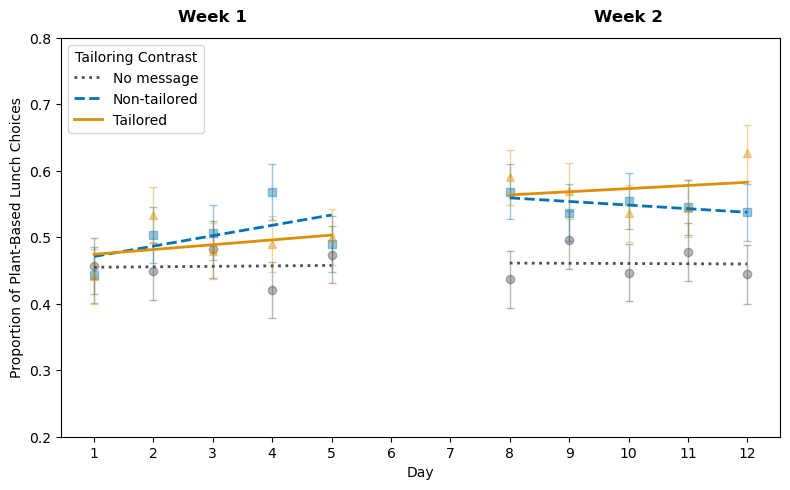

In [86]:
#We could also split the graph between the two weeks (but less preferred option)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define consistent Seaborn colorblind palette
# Grey for control, blue for non-tailored, orange for tailored
colors = {
    1.0: "#4D4D4D",   # dark grey
    2.0: "#0173B2",   # seaborn colorblind blue
    3.0: "#DE8F05"    # seaborn colorblind orange
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Plot dots with error bars (faded points)
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]
    plt.errorbar(
        sub["Day3"], sub["mean"], yerr=sub["sem"],
        fmt=markers[cond], color=colors[cond],
        ecolor=colors[cond], elinewidth=1, capsize=3,
        alpha=0.4, label=None
    )

# Plot separate regression lines for Days 1–5 and 8–12 (solid lines, not faded)
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]

    # First week (Days 1–5)
    sub_week1 = sub[(sub["Day3"] >= 1) & (sub["Day3"] <= 5)]
    sns.regplot(
        data=sub_week1, x="Day3", y="mean",
        scatter=False, ci=None, color=colors[cond],
        line_kws={'linestyle': linetypes[cond], 'linewidth': 2, 'alpha': 1, 'zorder': 5},
        label=None
    )

    # Second week (Days 8–12)
    sub_week2 = sub[(sub["Day3"] >= 8) & (sub["Day3"] <= 12)]
    sns.regplot(
        data=sub_week2, x="Day3", y="mean",
        scatter=False, ci=None, color=colors[cond],
        line_kws={'linestyle': linetypes[cond], 'linewidth': 2, 'alpha': 1, 'zorder': 5},
        label=label_map[cond]
    )

# Customize plot
plt.xlabel("Day")
plt.ylabel("Proportion of Plant-Based Lunch Choices")
plt.legend(title="Tailoring Contrast")
plt.ylim(0.2, 0.8)
plt.xticks(np.arange(1, 13, 1))

# Add Week 1 and Week 2 labels above the x-axis
plt.text(3, 0.82, "Week 1", ha="center", va="bottom", fontsize=12, weight="bold")
plt.text(10, 0.82, "Week 2", ha="center", va="bottom", fontsize=12, weight="bold")

plt.tight_layout()
plt.savefig("plant_based_lunch_tailoring_contrast.png", dpi=300, bbox_inches='tight')
plt.show()


In [54]:
summary['condition'].value_counts()

condition
1.0    10
2.0    10
3.0    10
Name: count, dtype: int64

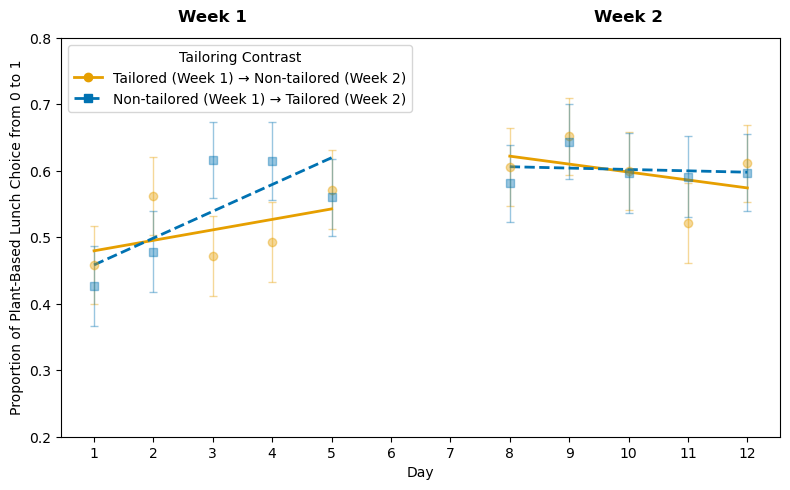

In [88]:
#We can also plot the difference across the Tailoring COntrast but for the within-subjects comparison

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Filter for relevant conditions
df = daily_surveys_filtered2[daily_surveys_filtered2['condition'].isin([4.0, 5.0])]

# Group and calculate mean and SEM
summary = df.groupby(["condition", "Day3"])["Lunch_plantbased2"].agg(['mean', 'sem']).reset_index()

# Define label mapping, linetypes, markers, and colors
label_map = {
    4.0: "Tailored (Week 1) → Non-tailored (Week 2)",
    5.0: "Non-tailored (Week 1) → Tailored (Week 2)"
}
linetypes = {4.0: "solid", 5.0: "dashed"}
markers = {4.0: "o", 5.0: "s"}
colors = {4.0: "#E69F00", 5.0: "#0072B2"}

# Set up the figure
plt.figure(figsize=(8, 5))


# Plot error bars
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]
    plt.errorbar(
        sub["Day3"], sub["mean"], yerr=sub["sem"],
        fmt=markers[cond], color=colors[cond],
        ecolor=colors[cond], elinewidth=1, capsize=3, alpha=0.4, label=None
    )

# Plot separate regression lines for each week
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]
    for week_days in [(1, 5), (7, 12)]:
        sub_week = sub[(sub["Day3"] >= week_days[0]) & (sub["Day3"] <= week_days[1])]
        sns.regplot(
            data=sub_week,
            x="Day3",
            y="mean",
            scatter=False,
            ci=None,
            color=colors[cond],
            line_kws={'linestyle': linetypes[cond], 'linewidth': 2},
            label=None
        )

# Create custom legend with mapped labels
legend_elements = [
    Line2D([0], [0], color=colors[cond], lw=2, linestyle=linetypes[cond],
           marker=markers[cond], label=label_map[cond])
    for cond in summary["condition"].unique()
]

# Customize plot
plt.xlabel("Day")
plt.ylabel("Proportion of Plant-Based Lunch Choice from 0 to 1")
plt.legend(handles=legend_elements, title="Tailoring Contrast")
plt.ylim(0.2, 0.8)
plt.xticks(np.arange(1, 13, 1))

# Add Week 1 and Week 2 labels above the x-axis
plt.text(3, 0.82, "Week 1", ha="center", va="bottom", fontsize=12, weight="bold")
plt.text(10, 0.82, "Week 2", ha="center", va="bottom", fontsize=12, weight="bold")


plt.tight_layout()
plt.savefig("plant_based_lunch_tailoring_contrast_4and5_splitweeks.png", dpi=300, bbox_inches='tight')
plt.show()


In [177]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Filter for relevant conditions
df = daily_surveys_filtered2[daily_surveys_filtered2['condition'].isin([4.0, 5.0])]

# Group and calculate mean and SEM
summary = df.groupby(["condition", "Day3"])["Lunch_plantbased2"].agg(['mean', 'sem']).reset_index()

# Define linetypes, markers, and colors
linetypes = {4.0: "solid", 5.0: "dashed"}
markers = {4.0: "o", 5.0: "s"}
colors  = {4.0: "#E69F00", 5.0: "#0072B2"}

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 5))

# Plot error bars
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]
    ax.errorbar(
        sub["Day3"], sub["mean"], yerr=sub["sem"],
        fmt=markers[cond], color=colors[cond],
        ecolor=colors[cond], elinewidth=1, capsize=3, alpha=0.4
    )

# Plot separate regression lines for each week
for cond in summary["condition"].unique():
    sub = summary[summary["condition"] == cond]
    for week_days in [(1, 5), (7, 12)]:
        sub_week = sub[(sub["Day3"] >= week_days[0]) & (sub["Day3"] <= week_days[1])]
        sns.regplot(
            data=sub_week,
            x="Day3", y="mean",
            scatter=False, ci=None,
            color=colors[cond],
            line_kws={'linestyle': linetypes[cond], 'linewidth': 2},
            ax=ax
        )

# ---- Remove labels, tick labels, legend, and extra text ----
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_ylim(0.2, 0.8)
ax.set_xticks(np.arange(1, 13, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])

# Remove legend if present
if ax.get_legend() is not None:
    ax.get_legend().remove()

# Remove any text labels (Week 1 / Week 2)
for t in ax.texts:
    t.set_visible(False)

plt.tight_layout()
plt.savefig("Figure3_withoutannotation.svg", format="svg", bbox_inches='tight')
plt.close()


### H2. Adolescents who receive daily linguistically tailored messages (vs. non-tailored messages) about plant-based eating will demonstrate (a) more positive message responses (e.g., message liking, message shareability, perceived relevance, perceived personalization, perceived style similarity) 

In [91]:
# Select relevant columns
cols_of_interest = ['Day3', 'Message_liking', 'Message_shareability', 'Message_relevance']

# Group by Day3 and calculate means
daily_means = daily_surveys_filtered2[cols_of_interest].groupby('Day3').mean().reset_index()

# Optionally round the results for readability
daily_means_rounded = daily_means.round(2)


In [92]:
daily_means_rounded

,Day3,Message_liking,Message_shareability,Message_relevance
0,1,2.53,2.36,5.85
1,2,2.54,2.39,5.86
2,3,2.53,2.47,5.86
3,4,2.59,2.45,5.92
4,5,2.51,2.70,5.80
5,8,2.60,2.51,5.10
6,9,2.54,2.49,5.88
7,10,2.56,2.51,5.82
8,11,2.60,2.52,6.00
9,12,2.62,2.55,5.99


In [95]:
#Lets check if the type of message that was sent had any effect on message responses

# Define theme mapping function
def assign_theme(day):
    if day in [1, 4, 8, 11]:
        return "Health"
    elif day in [2, 5, 9, 12]:
        return "Environment"
    elif day in [3, 10]:
        return "Animal Welfare"
    else:
        return "Unknown"

# Apply the mapping to create the new column
daily_means_rounded['Theme'] = daily_means_rounded['Day3'].apply(assign_theme)


In [96]:
daily_means_rounded.groupby(daily_means_rounded["Theme"]).mean()

,Day3,Message_liking,Message_shareability,Message_relevance
Theme,,,,
Animal Welfare,6.5,2.5450,2.4900,5.8400
Environment,7.0,2.5525,2.5325,5.8825
Health,6.0,2.5800,2.4600,5.7175


#### ...a) message liking

In [97]:
#First we will check message liking as first message response

In [764]:
daily_surveys_filtered2.groupby(["Tailored_contrast"])["Message_liking"].mean()
daily_surveys_filtered2.groupby(["condition"])["Message_liking"].mean()

condition
1.0         NaN
2.0    2.549699
3.0    2.560886
4.0    2.514327
5.0    2.634424
Name: Message_liking, dtype: float64

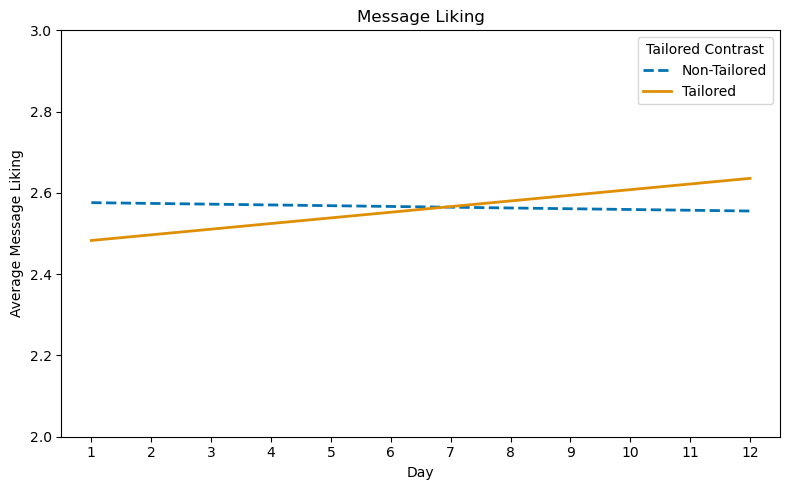

In [98]:
#Lets plot the Message liking variable

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Filter out the 0.0 condition (No message)
filtered = daily_surveys_filtered2[daily_surveys_filtered2["Tailored_contrast"].isin([-0.5, 0.5])]

# Group and calculate mean values
grouped = filtered.groupby(["Tailored_contrast", "Day3"])["Message_liking"].mean().reset_index()

# Define labels and linetypes
label_map = {
    -0.5: "Non-Tailored",
    0.5: "Tailored"
}
linetypes = {
    -0.5: "dashed",
    0.5: "solid"
}

# Set up the figure
plt.figure(figsize=(8, 5))
palette = sns.color_palette("colorblind", n_colors=2)
colors = dict(zip(grouped["Tailored_contrast"].unique(), palette))

# Plot each condition with its specific linetype
for condition in grouped["Tailored_contrast"].unique():
    sub = grouped[grouped["Tailored_contrast"] == condition]
    sns.regplot(
        data=sub,
        x="Day3",
        y="Message_liking",
        scatter=False,
        ci=None,
        color=colors[condition],
        line_kws={'linestyle': linetypes[condition], 'linewidth': 2},
        label=label_map[condition]
    )

# Customize plot
plt.title("Message Liking")
plt.xlabel("Day")
plt.ylabel("Average Message Liking")
plt.legend(title="Tailored Contrast")
plt.xlim(0.5, 12.5)
plt.ylim(2, 3)
plt.xticks(np.arange(1, 13, 1))
plt.tight_layout()
plt.savefig("message_liking.png", dpi=300, bbox_inches='tight')
plt.show()


In [100]:
#Descriptive Statistics

daily_surveys_filtered2["Message_liking"].groupby(daily_surveys_filtered2["Tailored_contrast"]).mean()

Tailored_contrast
-0.5    2.565173
 0.0         NaN
 0.5    2.560000
Name: Message_liking, dtype: float64

#### ...b) message shareability

In [844]:
daily_surveys_filtered2.groupby(["Tailored_contrast"])["Message_shareability"].mean()

Tailored_contrast
-0.5    2.452717
 0.0         NaN
 0.5    2.513015
Name: Message_shareability, dtype: float64

In [416]:

daily_surveys_filtered.groupby(["condition"])["Message_shareability"].mean()

condition
1.0         NaN
2.0    2.458163
3.0    2.528388
4.0    2.358921
5.0    2.491879
Name: Message_shareability, dtype: float64

In [1017]:
# Group by Tailored_contrast and Day, then get mean Message_relevance
grouped = daily_surveys_filtered2.groupby(["condition", "Day"])["Message_shareability"].mean().reset_index()

C:\Users\77197jsc\AppData\Local\Temp\ipykernel_6916\2506264790.py:26: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(


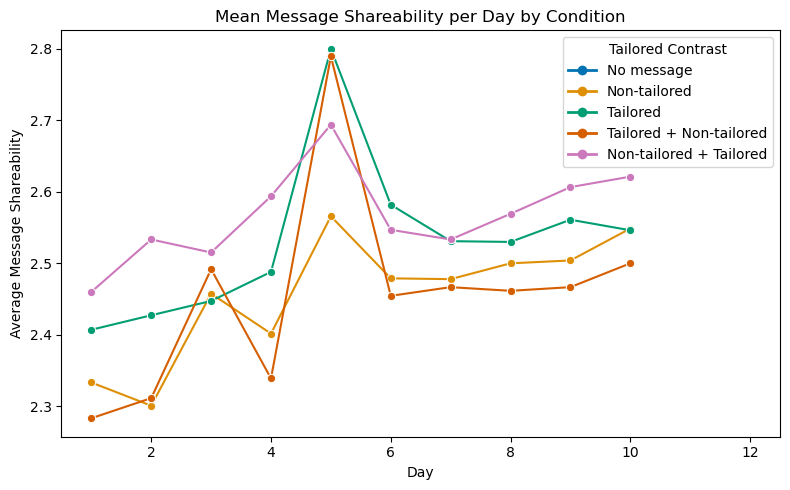

In [877]:
#Plotting the variable

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Example grouping (adjust to your actual DataFrame)
# Assuming daily_surveys_filtered is your source DataFrame
grouped = daily_surveys_filtered.groupby(["condition", "Day"])["Message_shareability"].mean().reset_index()

# Define custom label mapping for Tailored_contrast
label_map = {
    1: "No message",
    2: "Non-tailored",
    3: "Tailored",
    4: "Tailored + Non-tailored",
    5: "Non-tailored + Tailored",
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Use a distinct, colorblind-friendly palette
palette = sns.color_palette("colorblind")
colors = dict(zip(grouped["condition"].unique(), palette))

# Plot the lineplot
sns.lineplot(
    data=grouped,
    x="Day",
    y="Message_shareability",
    hue="condition",  # Corrected to match assumed column name
    marker="o",
    palette=palette,
    legend=False  # We'll add a custom legend
)

# Create custom legend with mapped labels
legend_elements = [
    Line2D([0], [0], color=colors[condition], lw=2, marker="o", 
           label=label_map.get(condition, f"Condition {condition}"))
    for condition in grouped["condition"].unique()
]

# Customize plot
plt.title("Mean Message Shareability per Day by Condition")
plt.xlabel("Day")
plt.ylabel("Average Message Shareability")
plt.xlim(0.5, 12.5)
plt.legend(handles=legend_elements, title="Tailored Contrast")
plt.tight_layout()
plt.show()

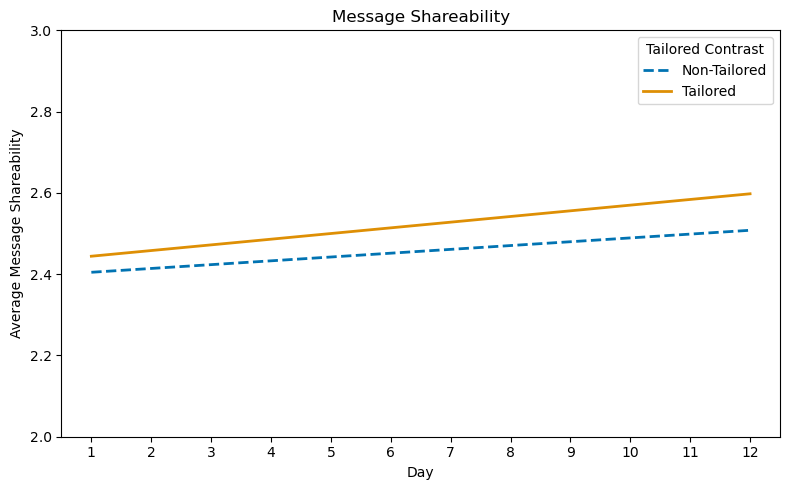

In [878]:
#Plotting the variable (linear)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Filter out the 0.0 condition (No message)
filtered = daily_surveys_filtered2[daily_surveys_filtered2["Tailored_contrast"].isin([-0.5, 0.5])]

# Group and calculate mean values
grouped = filtered.groupby(["Tailored_contrast", "Day3"])["Message_shareability"].mean().reset_index()

# Define labels and linetypes
label_map = {
    -0.5: "Non-Tailored",
    0.5: "Tailored"
}
linetypes = {
    -0.5: "dashed",
    0.5: "solid"
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Assign consistent colors
palette = sns.color_palette("colorblind", n_colors=2)
colors = dict(zip(grouped["Tailored_contrast"].unique(), palette))

# Plot each condition with specific linetype
for condition in grouped["Tailored_contrast"].unique():
    sub = grouped[grouped["Tailored_contrast"] == condition]
    sns.regplot(
        data=sub,
        x="Day3",
        y="Message_shareability",
        scatter=False,
        ci=None,
        color=colors[condition],
        line_kws={'linestyle': linetypes[condition], 'linewidth': 2},
        label=label_map[condition]
    )

# Customize plot
plt.title("Message Shareability")
plt.xlabel("Day")
plt.ylabel("Average Message Shareability")
plt.legend(title="Tailored Contrast")
plt.xticks(np.arange(1, 13, 1))
plt.xlim(0.5, 12.5)
plt.ylim(2, 3)
plt.tight_layout()
plt.savefig("message_shareability.png", dpi=300, bbox_inches='tight')
plt.show()


In [860]:
daily_surveys_filtered2["Message_shareability"].groupby(daily_surveys_filtered2["Tailored_contrast"]).mean()

Tailored_contrast
-0.5    2.447439
 0.0         NaN
 0.5    2.513015
Name: Message_shareability, dtype: float64

### ... perceived relevance

In [845]:
daily_surveys_filtered2.groupby(["Tailored_contrast"])["Message_relevance"].mean()

Tailored_contrast
-0.5    5.758865
 0.0         NaN
 0.5    5.840116
Name: Message_relevance, dtype: float64

In [862]:
daily_surveys_filtered2.groupby(["condition"])["Message_relevance"].mean()

condition
1.0         NaN
2.0    5.727927
3.0    5.861501
4.0    5.680993
5.0    5.922712
Name: Message_relevance, dtype: float64

In [863]:
# Group by Tailored_contrast and Day, then get mean Message_relevance
grouped = daily_surveys_filtered2.groupby(["condition", "Day"])["Message_relevance"].mean().reset_index()

C:\Users\77197jsc\AppData\Local\Temp\ipykernel_15640\3621914682.py:26: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(


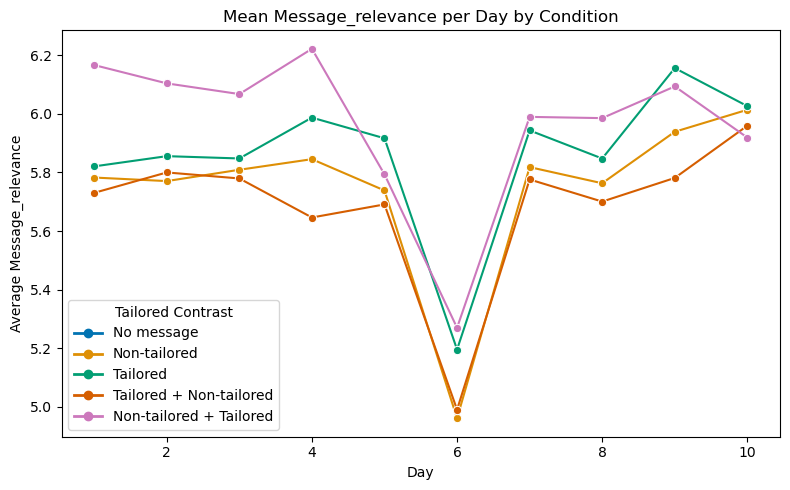

In [1023]:
#Plotting variable by Day

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Example grouping (adjust to your actual DataFrame)
# Assuming daily_surveys_filtered is your source DataFrame
grouped = daily_surveys_filtered.groupby(["condition", "Day"])["Message_relevance"].mean().reset_index()

# Define custom label mapping for Tailored_contrast
label_map = {
    1: "No message",
    2: "Non-tailored",
    3: "Tailored",
    4: "Tailored + Non-tailored",
    5: "Non-tailored + Tailored",
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Use a distinct, colorblind-friendly palette
palette = sns.color_palette("colorblind")
colors = dict(zip(grouped["condition"].unique(), palette))

# Plot the lineplot
sns.lineplot(
    data=grouped,
    x="Day",
    y="Message_relevance",
    hue="condition",  # Corrected to match assumed column name
    marker="o",
    palette=palette,
    legend=False  # We'll add a custom legend
)

# Create custom legend with mapped labels
legend_elements = [
    Line2D([0], [0], color=colors[condition], lw=2, marker="o", 
           label=label_map.get(condition, f"Condition {condition}"))
    for condition in grouped["condition"].unique()
]

# Customize plot
plt.title("Mean Message_relevance per Day by Condition")
plt.xlabel("Day")
plt.ylabel("Average Message_relevance")
plt.legend(handles=legend_elements, title="Tailored Contrast")
plt.tight_layout()
plt.show()

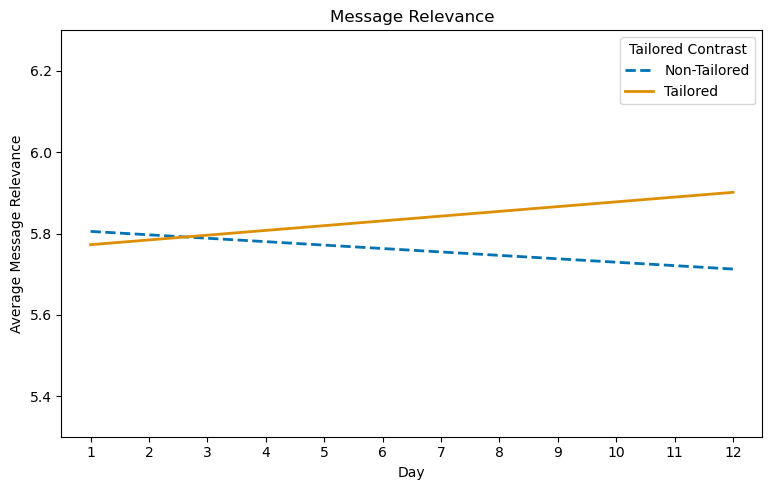

In [879]:
#Plotting variable (linear)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Filter out the 0.0 condition (No message)
filtered = daily_surveys_filtered2[daily_surveys_filtered2["Tailored_contrast"].isin([-0.5, 0.5])]

# Group and calculate mean values
grouped = filtered.groupby(["Tailored_contrast", "Day3"])["Message_relevance"].mean().reset_index()

# Define labels and linetypes
label_map = {
    -0.5: "Non-Tailored",
    0.5: "Tailored"
}
linetypes = {
    -0.5: "dashed",
    0.5: "solid"
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Use colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=2)
colors = dict(zip(grouped["Tailored_contrast"].unique(), palette))

# Plot regression lines by condition
for condition in grouped["Tailored_contrast"].unique():
    sub = grouped[grouped["Tailored_contrast"] == condition]
    sns.regplot(
        data=sub,
        x="Day3",
        y="Message_relevance",
        scatter=False,
        ci=None,
        color=colors[condition],
        line_kws={'linestyle': linetypes[condition], 'linewidth': 2},
        label=label_map[condition]
    )

# Customize plot
plt.title("Message Relevance")
plt.xlabel("Day")
plt.ylabel("Average Message Relevance")
plt.legend(title="Tailored Contrast")
plt.xticks(np.arange(1, 13, 1))
plt.xlim(0.5, 12.5)
plt.tight_layout()
plt.ylim(5.3,6.3)
plt.savefig("message_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


In [866]:
daily_surveys_filtered2["Message_relevance"].groupby(daily_surveys_filtered2["Tailored_contrast"]).mean()

Tailored_contrast
-0.5    5.754257
 0.0         NaN
 0.5    5.840116
Name: Message_relevance, dtype: float64

### d) ... perceived personalization

In [102]:
weekend_surveys.groupby(["Tailored_contrast"])["Message_personalized"].mean()

Tailored_contrast
-0.5    4.543237
 0.0         NaN
 0.5    4.732026
Name: Message_personalized, dtype: float64

In [103]:
# Group by Tailored_contrast and Day, then get mean Message_relevance
grouped = weekend_surveys.groupby(["condition", "week"])["Message_personalized"].mean().reset_index()

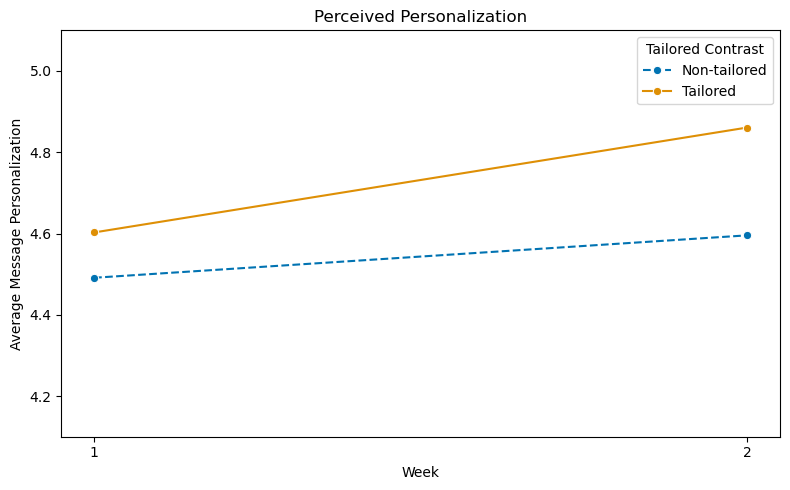

In [105]:
#Plotting the Variable

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Filter to keep only tailored vs. non-tailored (exclude 0.0 if present)
filtered = weekend_surveys[weekend_surveys["Tailored_contrast"].isin([-0.5, 0.5])]

# Group and calculate mean
grouped = filtered.groupby(["Tailored_contrast", "week"])["Message_personalized"].mean().reset_index()

# Define label and linetype mappings
label_map = {
    -0.5: "Non-tailored",
    0.5: "Tailored"
}
linetypes = {
    -0.5: "dashed",
    0.5: "solid"
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Use a colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=2)
colors = dict(zip(grouped["Tailored_contrast"].unique(), palette))

# Plot each line
for condition in grouped["Tailored_contrast"].unique():
    sub = grouped[grouped["Tailored_contrast"] == condition]
    sns.lineplot(
        data=sub,
        x="week",
        y="Message_personalized",
        color=colors[condition],
        linestyle=linetypes[condition],
        marker="o",
        label=label_map[condition]
    )

# Customize the plot
plt.title("Perceived Personalization")
plt.xlabel("Week")
plt.ylabel("Average Message Personalization")
plt.legend(title="Tailored Contrast")
plt.xticks([1, 2])
plt.ylim(4.1, 5.1)
plt.tight_layout()
plt.savefig("message_personalization.png", dpi=300, bbox_inches='tight')
plt.show()


### e) ... perceived style similarity

In [952]:
weekend_surveys.groupby(["Tailored_contrast"])["Message_similarity"].mean()

Tailored_contrast
-0.5    4.478936
 0.0         NaN
 0.5    4.607843
Name: Message_similarity, dtype: float64

In [953]:
# Group by Tailored_contrast and Day, then get mean Message_relevance
grouped = weekend_surveys.groupby(["condition", "week"])["Message_similarity"].mean().reset_index()

C:\Users\77197jsc\AppData\Local\Temp\ipykernel_15640\2949549458.py:25: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(


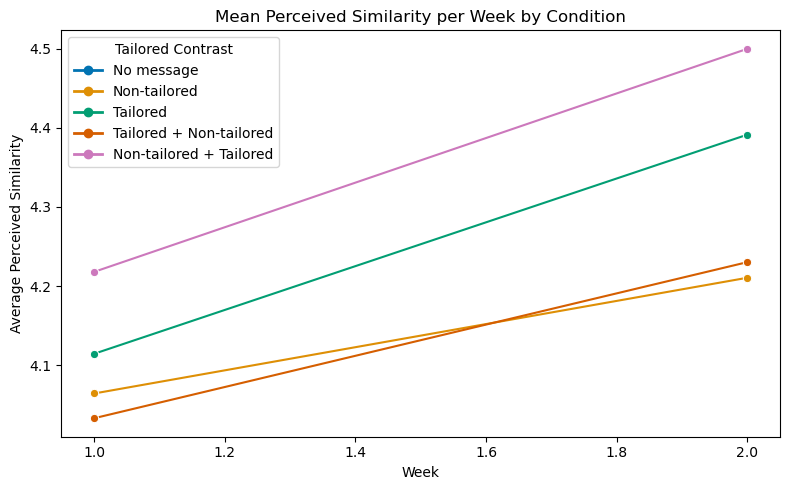

In [1029]:
#Plotting the Variable

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Group by condition and week, then get mean Perceived_similarity
grouped = weekend_surveys.groupby(["condition", "week"])["Message_similarity"].mean().reset_index()

# Define custom label mapping for condition
label_map = {
    1: "No message",
    2: "Non-tailored",
    3: "Tailored",
    4: "Tailored + Non-tailored",
    5: "Non-tailored + Tailored",
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Use a distinct, colorblind-friendly palette
palette = sns.color_palette("colorblind")
colors = dict(zip(grouped["condition"].unique(), palette))

# Plot the lineplot
sns.lineplot(
    data=grouped,
    x="week",
    y="Perceived_similarity",
    hue="condition",
    marker="o",
    palette=palette,
    legend=False  # We'll add a custom legend
)

# Create custom legend with mapped labels
legend_elements = [
    Line2D([0], [0], color=colors[condition], lw=2, marker="o", 
           label=label_map.get(condition, f"Condition {condition}"))
    for condition in grouped["condition"].unique()
]

# Customize plot
plt.title("Mean Perceived Similarity per Week by Condition")
plt.xlabel("Week")
plt.ylabel("Average Perceived Similarity")
plt.legend(handles=legend_elements, title="Tailored Contrast")
plt.tight_layout()
plt.show()

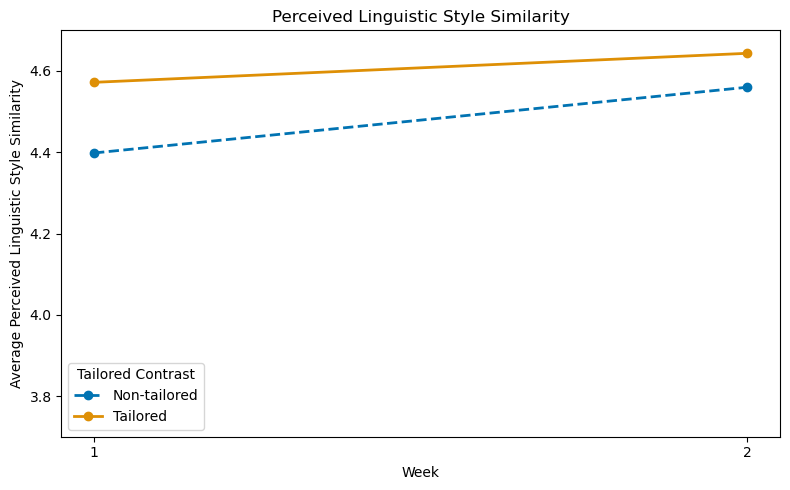

In [955]:
#Plotting the Variable

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Filter out condition == 0.0
grouped = weekend_surveys[weekend_surveys["Tailored_contrast"].isin([-0.5, 0.5])]
grouped = grouped.groupby(["Tailored_contrast", "week"])["Message_similarity"].mean().reset_index()

# Define label and linetype mappings
label_map = {
    -0.5: "Non-tailored",
    0.5: "Tailored"
}
linetypes = {
    -0.5: "dashed",
    0.5: "solid"
}

# Set up the figure
plt.figure(figsize=(8, 5))

# Use colorblind-friendly palette
palette = sns.color_palette("colorblind", n_colors=2)
colors = dict(zip([-0.5, 0.5], palette))

# Plot lines for each condition
for condition in [-0.5, 0.5]:
    sub = grouped[grouped["Tailored_contrast"] == condition]
    plt.plot(
        sub["week"],
        sub["Message_similarity"],
        label=label_map[condition],
        color=colors[condition],
        linestyle=linetypes[condition],
        marker="o",
        linewidth=2
    )

# Customize plot
plt.title("Perceived Linguistic Style Similarity")
plt.xlabel("Week")
plt.ylabel("Average Perceived Linguistic Style Similarity")
plt.xticks([1, 2])
plt.ylim(3.7, 4.7)
plt.legend(title="Tailored Contrast")
plt.tight_layout()
plt.savefig("perceived_similarity_by_week.png", dpi=300, bbox_inches='tight')
plt.show()


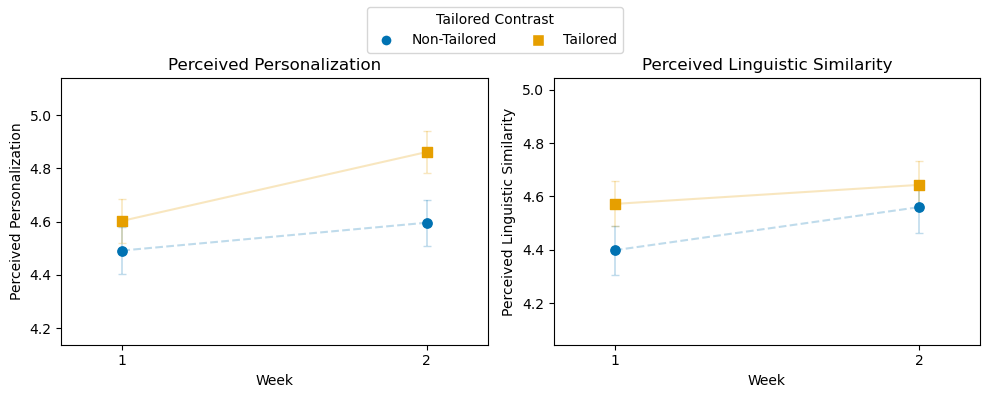

In [182]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# --- Grouped means and SE for weekend outcomes ---
df_personal = weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
    mean=("Message_personalized", "mean"),
    se=("Message_personalized", "sem")
).reset_index()

df_similarity = weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
    mean=("Message_similarity", "mean"),
    se=("Message_similarity", "sem")
).reset_index()

dfs = {
    "Perceived Personalization": df_personal,
    "Perceived Linguistic Similarity": df_similarity
}

colors = {-0.5: "#0072B2", 0.5: "#E69F00"}  # non-tailored, tailored
markers = {-0.5: "o", 0.5: "s"}             # circle, square
labels  = {-0.5: "Non-Tailored", 0.5: "Tailored"}

# --- 1x2 matrix ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, (title, df) in zip(axes, dfs.items()):
    for cond in [-0.5, 0.5]:
        sub = df[df["Tailored_contrast"] == cond]

        # Faded line: dashed for blue (-0.5), solid for orange (0.5)
        ax.plot(
            sub["week"], sub["mean"],
            color=colors[cond],
            linestyle="--" if cond == -0.5 else "-",
            alpha=0.25, linewidth=1.5
        )

        # Error bars (faded)
        ax.errorbar(
            sub["week"], sub["mean"], yerr=sub["se"],
            fmt=markers[cond], markersize=6,
            markerfacecolor=colors[cond], markeredgecolor=colors[cond],
            ecolor=colors[cond], elinewidth=1.2, capsize=3, alpha=0.25,
            linestyle="none"
        )

        # Overlay bold markers
        ax.scatter(
            sub["week"], sub["mean"],
            marker=markers[cond], s=45,
            color=colors[cond], label=labels[cond] if ax is axes[0] else None,
            zorder=3
        )

    # Tight x spacing and centered y-range
    mean_val = df["mean"].mean()
    ax.set_ylim(mean_val - 0.5, mean_val + 0.5)
    ax.set_xlim(0.8, 2.2)
    ax.set_xticks([1, 2])
    ax.set_xlabel("Week")
    ax.set_ylabel(title)
    ax.set_title(title)

# Custom legend: markers only
legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Non-Tailored",
           markerfacecolor=colors[-0.5], markersize=8),
    Line2D([0], [0], marker="s", color="w", label="Tailored",
           markerfacecolor=colors[0.5], markersize=8)
]
fig.legend(handles=legend_elements, title="Tailored Contrast",
           loc="upper center", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig("Figure5_annotated.png", dpi=300, bbox_inches="tight")
plt.show()


In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------
# DATA SOURCES
# -----------------------------
daily_sources = {
    "Message_liking":       (daily_surveys_filtered2, "Day3"),
    "Message_shareability": (daily_surveys_filtered2, "Day3"),
    "Message_relevance":    (daily_surveys_filtered2, "Day3"),
}

df_personal = weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
    mean=("Message_personalized", "mean"),
    se=("Message_personalized", "sem")
).reset_index()
df_similarity = weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
    mean=("Message_similarity", "mean"),
    se=("Message_similarity", "sem")
).reset_index()
weekend_sources = {
    "Perceived Personalization": df_personal,
    "Perceived Linguistic Similarity": df_similarity,
}

# -----------------------------
# STYLE
# -----------------------------
linetypes = {-0.5: "dashed", 0.5: "solid"}
colors    = {-0.5: "#0072B2",  0.5: "#E69F00"}
markers   = {-0.5: "o",        0.5: "s"}

# -----------------------------
# FIGURE: 3 x 2 grid
# -----------------------------
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()

# -----------------------------
# PLOT 1–3: DAILY
# -----------------------------
for ax, (y_col, (df_src, x_col)) in zip(axes[:3], daily_sources.items()):
    summary = (
        df_src.groupby(["Tailored_contrast", x_col])[y_col]
        .agg(['mean', 'sem'])
        .reset_index()
    )
    summary["sem"] = summary["sem"].fillna(0.0)
    mean_vals = []

    for cond in [-0.5, 0.5]:
        sub_raw = df_src[df_src["Tailored_contrast"] == cond]
        sub_sum = summary[summary["Tailored_contrast"] == cond]

        # Error bars
        ax.errorbar(
            sub_sum[x_col], sub_sum["mean"], yerr=sub_sum["sem"],
            fmt=markers[cond], color=colors[cond], ecolor=colors[cond],
            elinewidth=1, capsize=3, alpha=0.4
        )
        mean_vals.extend(sub_sum["mean"].tolist())

        # Regression line
        sns.regplot(
            data=sub_raw, x=x_col, y=y_col, ax=ax,
            scatter=False, ci=None, color=colors[cond],
            line_kws={'linestyle': linetypes[cond], 'linewidth': 2}
        )

    if mean_vals:
        mid = np.mean(mean_vals)
        ax.set_ylim(mid - 0.5, mid + 0.5)
    ax.set_xticks(np.arange(1, 13, 1))

# -----------------------------
# PLOT 4–5: WEEKEND
# -----------------------------
for ax, (title, df) in zip(axes[3:5], weekend_sources.items()):
    for cond in [-0.5, 0.5]:
        sub = df[df["Tailored_contrast"] == cond]

        # Faded line
        ax.plot(
            sub["week"], sub["mean"],
            color=colors[cond],
            linestyle="--" if cond == -0.5 else "-",
            alpha=0.25, linewidth=1.5
        )
        # Error bars
        ax.errorbar(
            sub["week"], sub["mean"], yerr=sub["se"],
            fmt=markers[cond], markersize=6,
            markerfacecolor=colors[cond], markeredgecolor=colors[cond],
            ecolor=colors[cond], elinewidth=1.2, capsize=3, alpha=0.25,
            linestyle="none"
        )
        # Crisp markers
        ax.scatter(
            sub["week"], sub["mean"],
            marker=markers[cond], s=45,
            color=colors[cond], zorder=3
        )

    mean_val = df["mean"].mean()
    ax.set_ylim(mean_val - 0.5, mean_val + 0.5)
    ax.set_xlim(0.8, 2.2)
    ax.set_xticks([1, 2])

# -----------------------------
# SLOT 6: Empty
# -----------------------------
fig.delaxes(axes[-1])

# -----------------------------
# STRIP ANNOTATIONS
# -----------------------------
for ax in axes:
    if not ax.has_data():
        continue
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    # Remove tick labels, keep tick marks
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Remove legend if present
if fig.legends:
    for lg in fig.legends:
        lg.remove()

# -----------------------------
# SAVE AS SVG
# -----------------------------
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("Figure3_no_annotations.svg", format="svg", bbox_inches="tight")
plt.close()


### 3a) ... source liking

In [107]:
weekend_surveys.groupby(["Tailored_contrast"])["Source_liking"].mean()

Tailored_contrast
-0.5    3.356984
 0.0         NaN
 0.5    3.428105
Name: Source_liking, dtype: float64

In [108]:
# Group by Tailored_contrast and Day, then get mean Message_relevance
grouped = weekend_surveys.groupby(["Tailored_contrast", "week"])["Source_liking"].mean().reset_index()

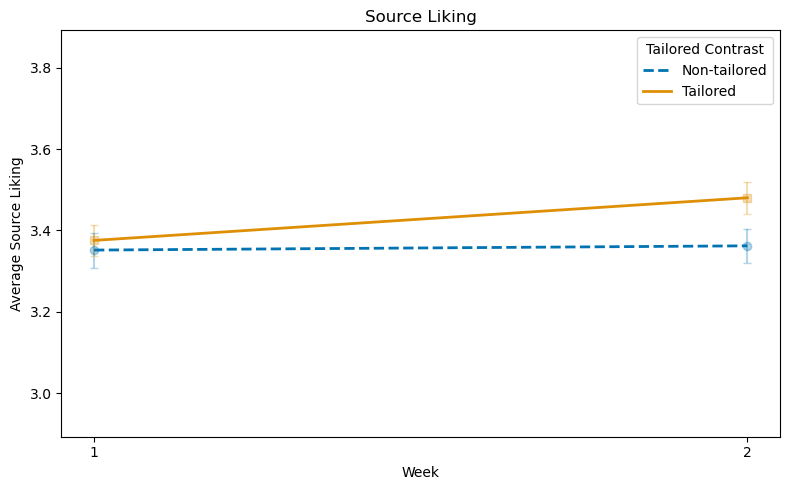

In [109]:
#Plotting the Variable

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

# Filter for conditions of interest
filtered = weekend_surveys[weekend_surveys["Tailored_contrast"].isin([-0.5, 0.5])]

# Compute mean and standard error
grouped = filtered.groupby(["Tailored_contrast", "week"]).agg(
    Source_liking=('Source_liking', 'mean'),
    se=('Source_liking', lambda x: x.std() / np.sqrt(len(x)))
).reset_index()

# Define label mapping, line styles, and colors
label_map = {-0.5: "Non-tailored", 0.5: "Tailored"}
linetypes = {-0.5: "dashed", 0.5: "solid"}
palette = sns.color_palette("colorblind")
colors = {-0.5: palette[0], 0.5: palette[1]}
markers = {-0.5: "o", 0.5: "s"}

# Compute mean for axis centering
mean_val = grouped["Source_liking"].mean()

# Set up the figure
plt.figure(figsize=(8, 5))

# Plot regression lines and error bars
for condition in grouped["Tailored_contrast"].unique():
    sub = grouped[grouped["Tailored_contrast"] == condition]

    # Regression line (smoothed)
    sns.regplot(
        data=sub,
        x="week",
        y="Source_liking",
        scatter=False,
        ci=None,
        color=colors[condition],
        line_kws={'linestyle': linetypes[condition], 'linewidth': 2},
        label=label_map[condition]
    )

    # Faded data points with SE bars
    plt.errorbar(
        sub["week"],
        sub["Source_liking"],
        yerr=sub["se"],
        fmt=markers[condition],
        color=colors[condition],
        alpha=0.3,
        capsize=3,
        markersize=6,
        linestyle='None'
    )

# Customize plot
plt.title("Source Liking")
plt.xlabel("Week")
plt.ylabel("Average Source Liking")
plt.xticks([1, 2])
plt.ylim(mean_val - 0.5, mean_val + 0.5)
plt.legend(title="Tailored Contrast")
plt.tight_layout()

# Save in high quality
plt.savefig("source_liking_plot.png", dpi=300, bbox_inches="tight", format="png")

# Show plot
plt.show()


In [110]:
#Running the Analysis

# First: define the exact columns you use in your model
cols = [
    "Source_liking",
    "Tailored_contrast",
    "week",
    "Name",
    "Country_of_residence",
    'Dietary_identity', 
    'Children_age_years', 
    'Birthplace_parents', 
    'SES',
    'Birthplace_parents',
    "Gender_dummy",
    "Imposter",
]

# Drop rows where any of these columns are missing
df_model = weekend_surveys.dropna(subset=cols)

# Replace value 7 with NaN in 'Dietary_identity'
df_model['Dietary_identity'] = df_model['Dietary_identity'].replace(7, np.nan)
df_model = df_model.dropna(subset=cols)

# Define columns to treat as categorical (factors)
factor_cols = [
    "Name",
    "Country_of_residence",
    "Dietary_identity",
    "Birthplace_parents"
]

# Convert these columns to categorical dtype
for col in factor_cols:
    df_model[col] = df_model[col].astype('category')

# Now fit the model
import statsmodels.formula.api as smf

model = smf.mixedlm(
    "Source_liking ~ Tailored_contrast + week + Tailored_contrast:week + Dietary_identity + SES + Country_of_residence + Gender_dummy + Imposter + Children_age_years",
    data=df_model,
    groups=df_model["Name"],
    re_formula=None
)

result = model.fit()
print(result.summary())

C:\Users\77197jsc\AppData\Local\Temp\ipykernel_9388\2544487967.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['Dietary_identity'] = df_model['Dietary_identity'].replace(7, np.nan)


                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    Source_liking
No. Observations:      896        Method:                REML         
No. Groups:            450        Scale:                 0.0854       
Min. group size:       1          Log-Likelihood:        -621.8529    
Max. group size:       2          Converged:             Yes          
Mean group size:       2.0                                            
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                    2.708    0.148 18.277 0.000  2.418  2.998
Dietary_identity[T.2.0]      0.007    0.174  0.041 0.967 -0.335  0.349
Dietary_identity[T.3.0]      0.168    0.074  2.275 0.023  0.023  0.313
Country_of_residence[T.2.0] -0.084    0.210 -0.400 0.689 -0.495  0.327
Country_of_residence[T.

### 3b) ... source trust

In [942]:
weekend_surveys.groupby(["Tailored_contrast"])["Source_trust"].mean()

Tailored_contrast
-0.5    3.359581
 0.0         NaN
 0.5    3.412309
Name: Source_trust, dtype: float64

In [943]:
# Group by Tailored_contrast and Day, then get mean Message_relevance
grouped = weekend_surveys.groupby(["Tailored_contrast", "week"])["Source_trust"].mean().reset_index()

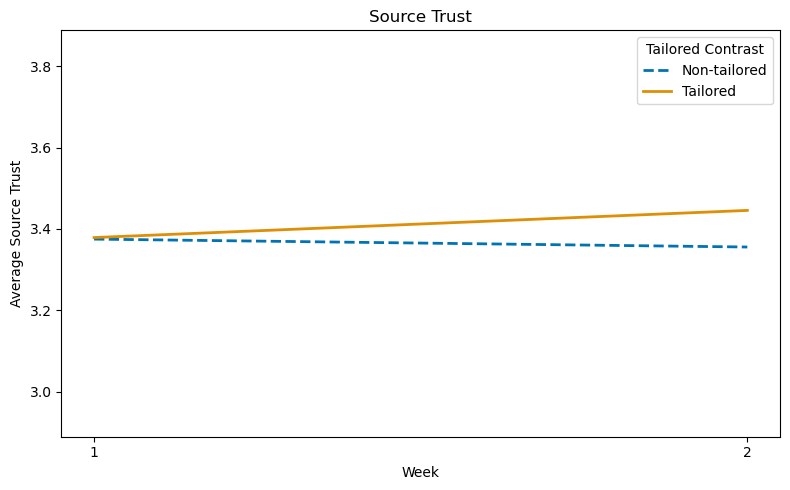

In [909]:
Plotting the Variable

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Filter to include only tailored vs. non-tailored conditions
grouped = weekend_surveys[weekend_surveys["Tailored_contrast"].isin([-0.5, 0.5])]
grouped = grouped.groupby(["Tailored_contrast", "week"])["Source_trust"].mean().reset_index()

# Define label mapping and line types
label_map = {
    -0.5: "Non-tailored",
    0.5: "Tailored"
}
linetypes = {
    -0.5: "dashed",
    0.5: "solid"
}

# Use colorblind-friendly palette
palette = sns.color_palette("colorblind")
colors = dict(zip(grouped["Tailored_contrast"].unique(), palette))

# Compute mean for centering y-axis
mean_val = grouped["Source_trust"].mean()

# Set up the figure
plt.figure(figsize=(8, 5))

# Plot regression lines with custom styles
for condition in grouped["Tailored_contrast"].unique():
    sub = grouped[grouped["Tailored_contrast"] == condition]
    sns.regplot(
        data=sub,
        x="week",
        y="Source_trust",
        scatter=False,
        ci=None,
        color=colors[condition],
        line_kws={'linestyle': linetypes[condition], 'linewidth': 2},
        label=label_map[condition]
    )

# Customize plot
plt.title("Source Trust")
plt.xlabel("Week")
plt.ylabel("Average Source Trust")
plt.xticks([1, 2])
plt.ylim(mean_val - 0.5, mean_val + 0.5)
plt.legend(title="Tailored Contrast")
plt.tight_layout()
plt.show()


### 3c) ... perceived source similarity

In [946]:
weekend_surveys.groupby(["Tailored_contrast"])["Perceived_similarity"].mean()

Tailored_contrast
-0.5    4.167401
 0.0         NaN
 0.5    4.258170
Name: Perceived_similarity, dtype: float64

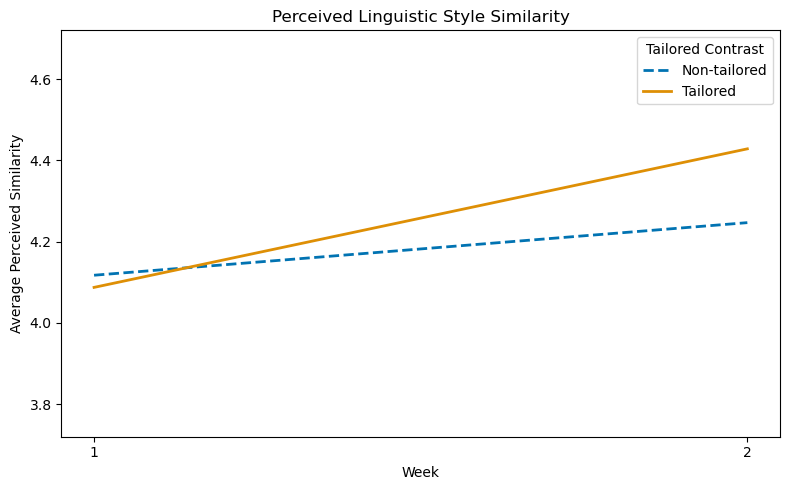

In [111]:
#Plotting the Variable

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Filter to include only tailored and non-tailored
grouped = weekend_surveys[weekend_surveys["Tailored_contrast"].isin([-0.5, 0.5])]
grouped = grouped.groupby(["Tailored_contrast", "week"])["Perceived_similarity"].mean().reset_index()

# Label, linetype, and color mappings
label_map = {
    -0.5: "Non-tailored",
    0.5: "Tailored"
}
linetypes = {
    -0.5: "dashed",
    0.5: "solid"
}
palette = sns.color_palette("colorblind")
colors = dict(zip(grouped["Tailored_contrast"].unique(), palette))

# Compute mean for centering y-axis
mean_val = grouped["Perceived_similarity"].mean()

# Set up the figure
plt.figure(figsize=(8, 5))

# Plot linear regression lines
for condition in grouped["Tailored_contrast"].unique():
    sub = grouped[grouped["Tailored_contrast"] == condition]
    sns.regplot(
        data=sub,
        x="week",
        y="Perceived_similarity",
        scatter=False,
        ci=None,
        color=colors[condition],
        line_kws={'linestyle': linetypes[condition], 'linewidth': 2},
        label=label_map[condition]
    )

# Customize plot
plt.title("Perceived Linguistic Style Similarity")
plt.xlabel("Week")
plt.ylabel("Average Perceived Similarity")
plt.xticks([1, 2])
plt.ylim(mean_val - 0.5, mean_val + 0.5)
plt.legend(title="Tailored Contrast")
plt.tight_layout()
plt.show()


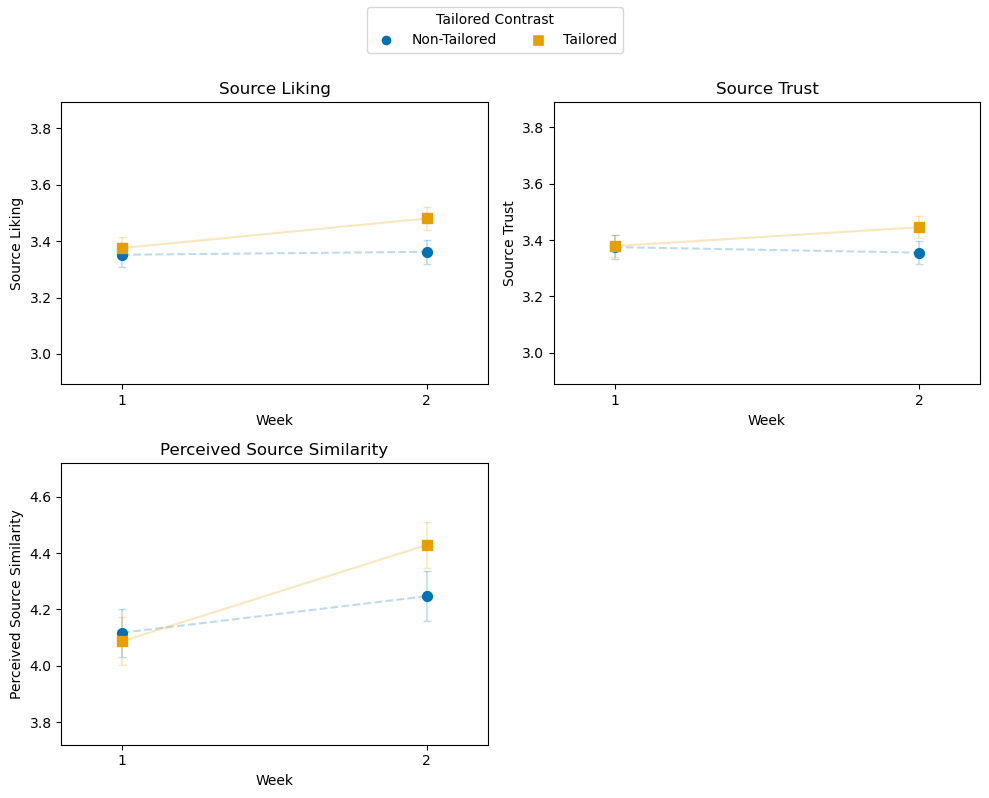

In [183]:
#Again lets construct a Plot Matrix for All Source Reponse Variables

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Grouped means and standard errors
dfs = {
    "Source_liking": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Source_liking", "mean"), se=("Source_liking", "sem")).reset_index(),
    "Source_trust": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Source_trust", "mean"), se=("Source_trust", "sem")).reset_index(),
    "Perceived_similarity": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Perceived_similarity", "mean"), se=("Perceived_similarity", "sem")).reset_index()
}

custom_titles = {
    "Source_liking": "Source Liking",
    "Source_trust": "Source Trust",
    "Perceived_similarity": "Perceived Source Similarity"
}

# Colors & markers
colors = {-0.5: "#0072B2", 0.5: "#E69F00"}  # non-tailored, tailored
markers = {-0.5: "o", 0.5: "s"}             # circle, square
labels  = {-0.5: "Non-Tailored", 0.5: "Tailored"}

# >>> Make each axis ~5x4 inches (same as earlier matrix boxes)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # <-- changed from (12, 7)
axes = axes.flatten()
fig.delaxes(axes[-1])  # remove 4th panel

# Plotting loop
for ax, (var, df) in zip(axes, dfs.items()):
    for cond in [-0.5, 0.5]:
        sub = df[df["Tailored_contrast"] == cond]

        # Faded line: blue dashed, orange solid
        ax.plot(
            sub["week"], sub["mean"],
            color=colors[cond],
            linestyle="--" if cond == -0.5 else "-",
            alpha=0.25, linewidth=1.5
        )

        # Error bars (faded)
        ax.errorbar(
            sub["week"], sub["mean"], yerr=sub["se"],
            fmt=markers[cond], markersize=6,
            markerfacecolor=colors[cond], markeredgecolor=colors[cond],
            ecolor=colors[cond], elinewidth=1.2, capsize=3, alpha=0.25,
            linestyle="none"
        )

        # Overlay crisp markers
        ax.scatter(
            sub["week"], sub["mean"],
            marker=markers[cond], s=50,
            color=colors[cond], label=labels[cond] if ax is axes[0] else None,
            zorder=3
        )

    # Axis formatting
    mean_val = df["mean"].mean()
    ax.set_ylim(mean_val - 0.5, mean_val + 0.5)
    ax.set_xlim(0.8, 2.2)
    ax.set_xticks([1, 2])
    ax.set_xlabel("Week")
    ax.set_ylabel(custom_titles[var])
    ax.set_title(custom_titles[var])


# Legend
legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Non-Tailored",
           markerfacecolor=colors[-0.5], markersize=8),
    Line2D([0], [0], marker="s", color="w", label="Tailored",
           markerfacecolor=colors[0.5], markersize=8)
]
fig.legend(handles=legend_elements, title="Tailored Contrast",
           loc="upper center", ncol=2)

# Slightly tighter layout, same top margin as before
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("Figure6_annotated.png", dpi=300, bbox_inches="tight")
plt.show()


In [184]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Grouped means and standard errors
dfs = {
    "Source_liking": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Source_liking", "mean"), se=("Source_liking", "sem")).reset_index(),
    "Source_trust": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Source_trust", "mean"), se=("Source_trust", "sem")).reset_index(),
    "Perceived_similarity": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Perceived_similarity", "mean"), se=("Perceived_similarity", "sem")).reset_index()
}

# Colors & markers
colors = {-0.5: "#0072B2", 0.5: "#E69F00"}  # non-tailored, tailored
markers = {-0.5: "o", 0.5: "s"}             # circle, square

# 2x2 grid (one empty)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
fig.delaxes(axes[-1])

# Plotting loop
for ax, (var, df) in zip(axes, dfs.items()):
    for cond in [-0.5, 0.5]:
        sub = df[df["Tailored_contrast"] == cond]

        # Faded line: blue dashed, orange solid
        ax.plot(
            sub["week"], sub["mean"],
            color=colors[cond],
            linestyle="--" if cond == -0.5 else "-",
            alpha=0.25, linewidth=1.5
        )

        # Error bars (faded)
        ax.errorbar(
            sub["week"], sub["mean"], yerr=sub["se"],
            fmt=markers[cond], markersize=6,
            markerfacecolor=colors[cond], markeredgecolor=colors[cond],
            ecolor=colors[cond], elinewidth=1.2, capsize=3, alpha=0.25,
            linestyle="none"
        )

        # Overlay crisp markers
        ax.scatter(
            sub["week"], sub["mean"],
            marker=markers[cond], s=50,
            color=colors[cond], label=labels[cond] if ax is axes[0] else None,
            zorder=3
        )


    # Axis formatting
    mean_val = df["mean"].mean()
    ax.set_ylim(mean_val - 0.5, mean_val + 0.5)
    ax.set_xlim(0.8, 2.2)
    ax.set_xticks([1, 2])

    # --- Remove annotations ---
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Remove legend if present
if fig.legends:
    for leg in fig.legends:
        leg.remove()

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig("Figure6_no_annotations.svg", format="svg", bbox_inches="tight")
plt.close()


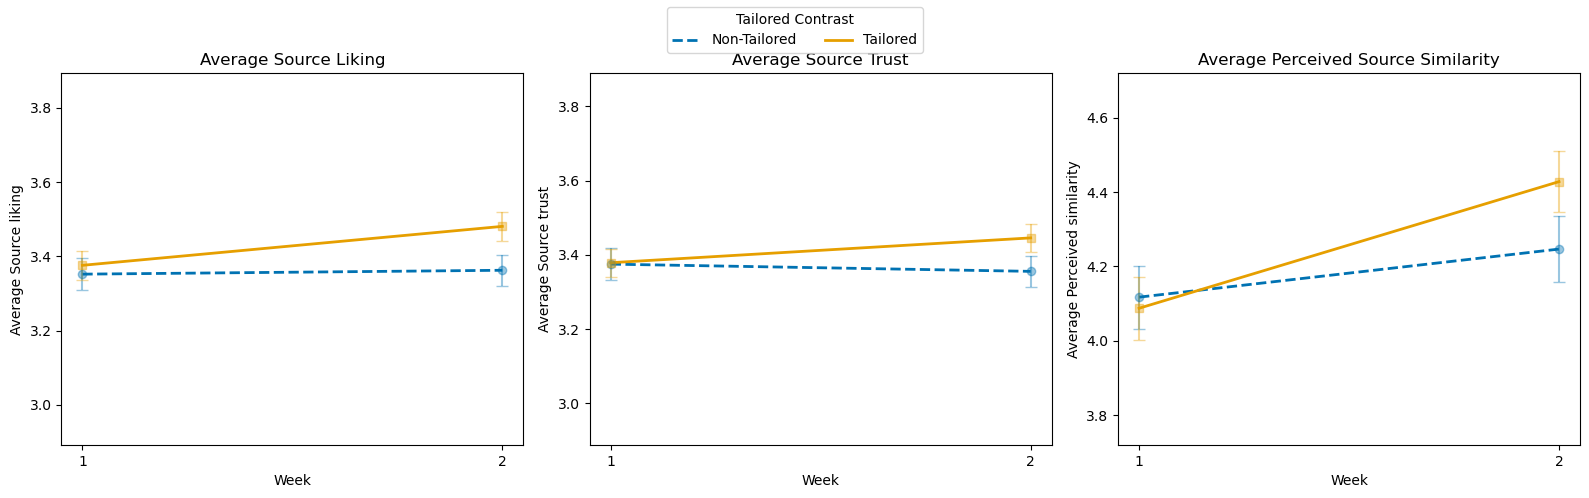

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Grouped means and standard errors
dfs = {
    "Source_liking": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Source_liking", "mean"), se=("Source_liking", "sem")).reset_index(),
    "Source_trust": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Source_trust", "mean"), se=("Source_trust", "sem")).reset_index(),
    "Perceived_similarity": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Perceived_similarity", "mean"), se=("Perceived_similarity", "sem")).reset_index()
}

custom_titles = {
    "Source_liking": "Source Liking",
    "Source_trust": "Source Trust",
    "Perceived_similarity": "Perceived Source Similarity"
}

linetypes = {-0.5: "dashed", 0.5: "solid"}
colors = {-0.5: "#0072B2", 0.5: "#E69F00"}
markers = {-0.5: "o", 0.5: "s"}  # Circle for non-tailored, square for tailored
label_map = {-0.5: "Non-Tailored", 0.5: "Tailored"}

# Set up 1x3 plot grid
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plotting loop
for ax, (var, df) in zip(axes, dfs.items()):
    for cond in [-0.5, 0.5]:
        sub = df[df["Tailored_contrast"] == cond]
        
        # Line plot
        sns.regplot(
            x="week", y="mean", data=sub, ax=ax,
            scatter=False, ci=None, color=colors[cond],
            line_kws={'linestyle': linetypes[cond], 'linewidth': 2},
            label=label_map[cond]
        )

        # Error bars and faded points
        ax.errorbar(
            sub["week"], sub["mean"], yerr=sub["se"],
            fmt=markers[cond], markersize=6,
            color=colors[cond], alpha=0.4, capsize=4, linestyle='none'
        )

    mean_val = df["mean"].mean()
    ax.set_ylim(mean_val - 0.5, mean_val + 0.5)
    ax.set_title(f"Average {custom_titles.get(var, var.replace('_', ' '))}")
    ax.set_xlabel("Week")
    ax.set_ylabel(f"Average {var.replace('_', ' ')}")
    ax.set_xticks([1, 2])

# Shared legend and layout
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Tailored Contrast", loc='upper center', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig("tailoring_matrix_source_row.png", dpi=300, bbox_inches="tight")
plt.show()


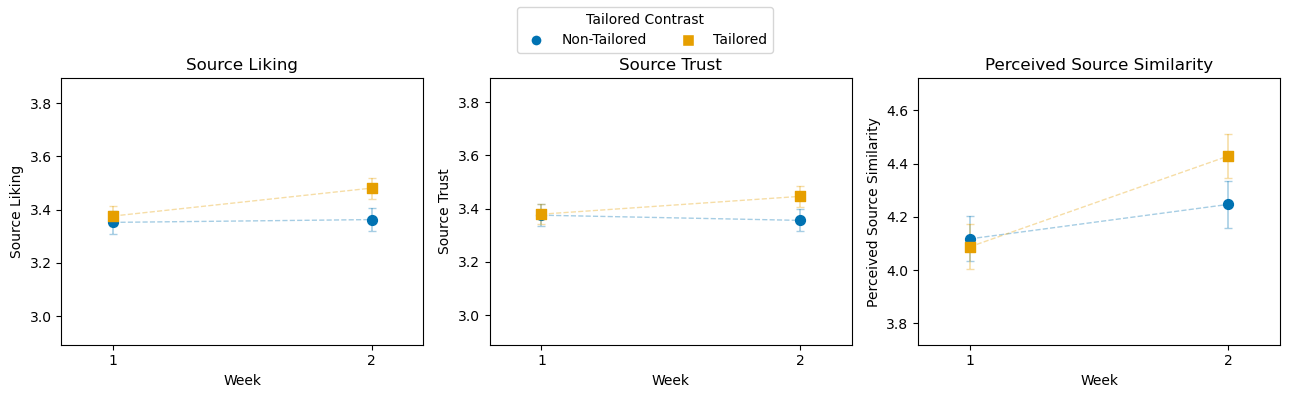

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

# Grouped means and standard errors
dfs = {
    "Source_liking": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Source_liking", "mean"), se=("Source_liking", "sem")).reset_index(),
    "Source_trust": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Source_trust", "mean"), se=("Source_trust", "sem")).reset_index(),
    "Perceived_similarity": weekend_surveys.groupby(["Tailored_contrast", "week"]).agg(
        mean=("Perceived_similarity", "mean"), se=("Perceived_similarity", "sem")).reset_index()
}

custom_titles = {
    "Source_liking": "Source Liking",
    "Source_trust": "Source Trust",
    "Perceived_similarity": "Perceived Source Similarity"
}

# Colors & markers (non-tailored, tailored)
colors = {-0.5: "#0072B2", 0.5: "#E69F00"}
markers = {-0.5: "o", 0.5: "s"}
labels  = {-0.5: "Non-Tailored", 0.5: "Tailored"}

# 1x3 plot grid
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

for ax, (var, df) in zip(axes, dfs.items()):
    for cond in [-0.5, 0.5]:
        sub = df[df["Tailored_contrast"] == cond]

        # Thin faded guidance line
        ax.plot(
            sub["week"], sub["mean"],
            color=colors[cond], linestyle="--", alpha=0.35, linewidth=1
        )

        # Faded error bars
        ax.errorbar(
            sub["week"], sub["mean"], yerr=sub["se"],
            fmt=markers[cond], markersize=0,   # size 0 here; we'll overlay crisp markers next
            ecolor=colors[cond], elinewidth=1.2, capsize=3, alpha=0.35,
            linestyle="none"
        )

        # Overlay crisp markers (no fade)
        ax.scatter(
            sub["week"], sub["mean"],
            marker=markers[cond], s=50,
            color=colors[cond],
            label=labels[cond] if ax is axes[0] else None,
            zorder=3
        )

    # Center y-range around mean and tighten x-range
    mean_val = df["mean"].mean()
    ax.set_ylim(mean_val - 0.5, mean_val + 0.5)
    ax.set_xlim(0.8, 2.2)
    ax.set_xticks([1, 2])
    ax.set_xlabel("Week")
    ax.set_ylabel(custom_titles[var])
    ax.set_title(custom_titles[var])

# Custom legend: markers only (no lines/errorbars)
legend_elements = [
    Line2D([0], [0], marker="o", color="w", label="Non-Tailored",
           markerfacecolor=colors[-0.5], markersize=8),
    Line2D([0], [0], marker="s", color="w", label="Tailored",
           markerfacecolor=colors[0.5], markersize=8)
]
fig.legend(handles=legend_elements, title="Tailored Contrast",
           loc="upper center", ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig("tailoring_matrix_source_row_fadedSE_crispMarkers.png", dpi=300, bbox_inches="tight")
plt.show()
